<a href="https://colab.research.google.com/github/mai-mohamed21/Flora-SmartFarmingCompanion/blob/main/flora_diseasedplant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Mount Google Drive & Download Dataset**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset
import zipfile
with zipfile.ZipFile("plantvillage-dataset.zip","r") as zip_ref:
    zip_ref.extractall("plantvillage")

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 97% 1.97G/2.04G [00:25<00:02, 32.0MB/s]
100% 2.04G/2.04G [00:25<00:00, 86.5MB/s]


In [ ]:
import os

data_dir = "plantvillage/plantvillage dataset/color"

print("Number of categories:", len(os.listdir(data_dir)))
print("First 5 categories:", os.listdir(data_dir)[:5])

Number of categories: 38
First 5 categories: ['Tomato___Bacterial_spot', 'Corn_(maize)___Common_rust_', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___healthy', 'Grape___healthy']


### **Key Insight**

We observe a clear and consistent naming pattern in the categories:

- **Format:** PlantName___Condition
- **Examples:**
  - Grape___healthy : A **healthy** grape leaf
  - Tomato___Septoria_leaf_spot : A tomato leaf with **Septoria leaf spot** disease

  
---

## **Import Libraries**

In [ ]:
!pip install -q mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.4/2

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import transforms,models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from tqdm import tqdm
import mlflow
import mlflow.pytorch
import optuna
from sklearn.metrics import f1_score, classification_report, confusion_matrix,precision_score, recall_score,accuracy_score
import numpy as np
from collections import Counter
import random
import torch.nn.functional as F

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# **Exploratory Data Analysis (EDA) -Flora 🌿**

---




## **Show sample images**

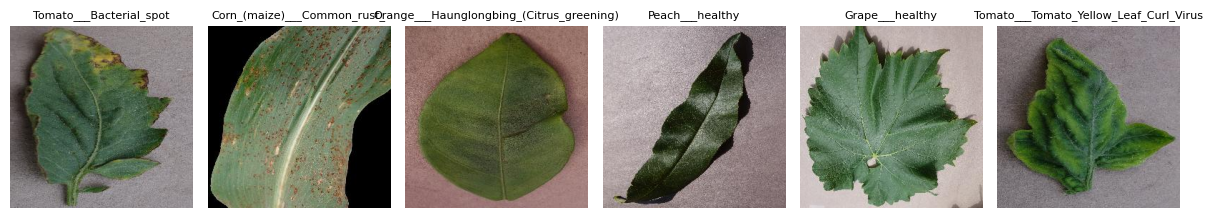

In [ ]:
categories = os.listdir(data_dir)
plt.figure(figsize=(12, 4))
for i, category in enumerate(categories[:6]):
    category_path = os.path.join(data_dir, category)
    img_name = os.listdir(category_path)[0]
    img_path = os.path.join(category_path, img_name)

    img = Image.open(img_path)

    plt.subplot(1, 6, i+1)
    plt.imshow(img)
    plt.title(category, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Count images per category**



In [ ]:
image_counts = {c: len(os.listdir(os.path.join(data_dir, c))) for c in categories}
df_counts = pd.DataFrame(list(image_counts.items()), columns=['Category', 'Number of Images'])
df_counts = df_counts.sort_values(by='Number of Images', ascending=False)
df_counts.reset_index(drop=True, inplace=True)
df_counts

,Category,Number of Images
0,Orange___Haunglongbing_(Citrus_greening),5507
1,Tomato___Tomato_Yellow_Leaf_Curl_Virus,5357
2,Soybean___healthy,5090
3,Peach___Bacterial_spot,2297
4,Tomato___Bacterial_spot,2127
5,Tomato___Late_blight,1909
6,Squash___Powdery_mildew,1835
7,Tomato___Septoria_leaf_spot,1771
8,Tomato___Spider_mites Two-spotted_spider_mite,1676
9,Apple___healthy,1645


## **Image distribution**

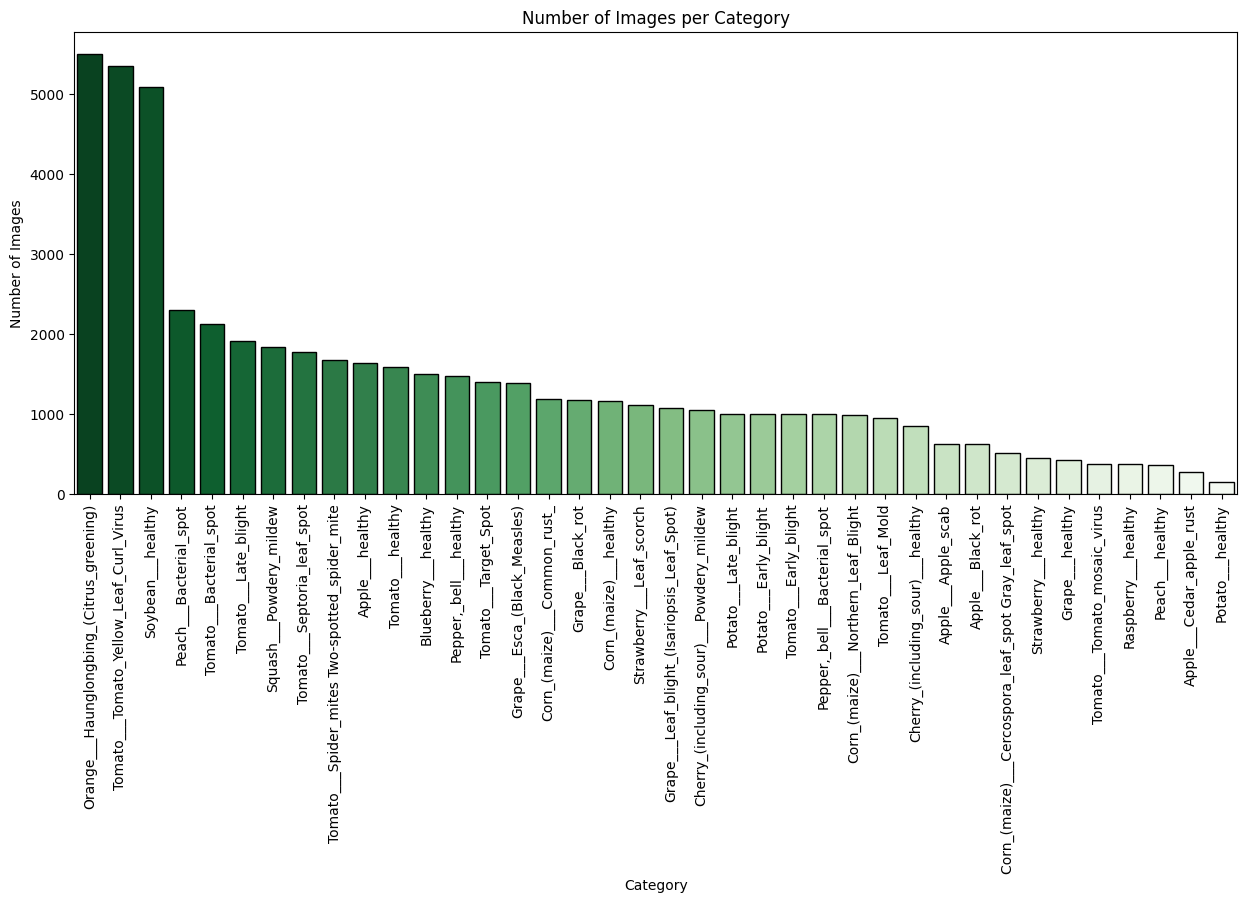

In [ ]:
plt.figure(figsize=(15,6))
sns.barplot(
    x='Category',
    y='Number of Images',
    data=df_counts,
    hue='Category',
    palette='Greens_r',
    edgecolor='black'
)

plt.xticks(rotation=90)
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.title("Number of Images per Category")
plt.show()

### **Dataset Analysis: Key Insights & Actions**

| Insight | Observation | Recommended Action |
| :--- | :--- | :--- |
| **🍎 Class Imbalance** | Extreme variance in samples (e.g., 5,507 vs. 152 images). | Use **hybrid methods** like class weighting or oversampling (e.g.,Augmentation&Class Weight) for minority classes. |
| **🍅 Tomato Dominance** | Tomato diseases are highly represented in the dataset. | Model will excel on tomatoes but needs augmented data for underrepresented crops (e.g., potato, grape). |
| **🌿 Disease Diversity** | Wide variety of diseases and healthy states across species. | Excellent for building a **general-purpose model** for plant disease diagnosis. |
| **✅ Healthy Representation** | Inconsistent healthy sample counts (e.g., Soybean: 5,090 vs. Potato: 152). | Apply **targeted augmentation** (rotations, flips, lighting changes) for healthy classes with low samples. |

------

## **Image size distribution**

In [ ]:
sizes = []

for category in categories:
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        try:
            img = Image.open(img_path)
            sizes.append(img.size)
        except:
           print(f" Problem with image: {img_path}")

size_counts = Counter(sizes)

print(f"Total images: {len(sizes)}")
print(f"Number of unique sizes: {len(size_counts)}")
print("Top 10 most common sizes:")
for size, count in size_counts.most_common(10):
    print(size, ":", count)

Total images: 54305
Number of unique sizes: 1
Top 10 most common sizes:
(256, 256) : 54305


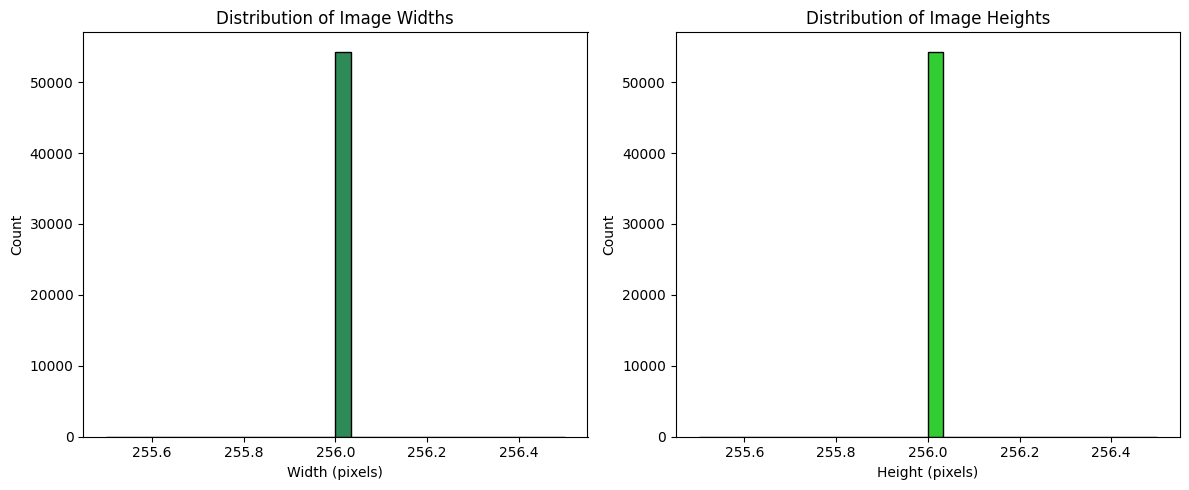

In [ ]:
widths = [w for (w, h) in sizes]
heights = [h for (w, h) in sizes]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(widths, bins=30, color='seagreen', edgecolor='black')
plt.title("Distribution of Image Widths")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(heights, bins=30, color='limegreen', edgecolor='black')
plt.title("Distribution of Image Heights")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

### **Image Size Standardization**

- *Original Size:* All images pre-sized to 256×256 pixels
- *Processing:* Resized to 128×128 for efficiency
- *Benefits:*
  - *Faster training* with reduced computational requirements
  - *Lower memory usage* (RAM/GPU)
  - *Uniform input* for CNN models (EfficientNet, ResNet)
  - *Eliminates resolution bias* - no spurious size-related patterns
  - *Optimized batch processing* with consistent dimensions

---------

## **Healthy vs Diseased Pie Chart**

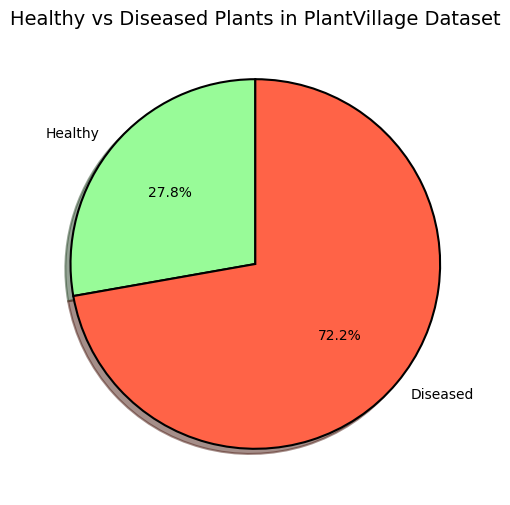

In [ ]:
healthy_count = df_counts[df_counts['Category'].str.contains("healthy", case=False)]['Number of Images'].sum()
diseased_count = df_counts['Number of Images'].sum() - healthy_count

summary_df = pd.DataFrame({
    "Condition": ["Healthy", "Diseased"],
    "Count": [healthy_count, diseased_count]
})


plt.figure(figsize=(6, 6))
colors = ['palegreen', 'tomato']
plt.pie( summary_df['Count'],
    labels=summary_df['Condition'],
    autopct='%1.1f%%',
    colors=colors,
    shadow=True,
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
plt.title("Healthy vs Diseased Plants in PlantVillage Dataset", fontsize=14)
plt.show()

### **Class Imbalance Alert**

**-72.8% Diseased** vs. **27.2% Healthy** plants

**-Implication:** High risk of model bias toward predicting "diseased"

**-Solution:** Use class weights or oversampling during training

---------

# **Preprocessing & Dataset Class**

---



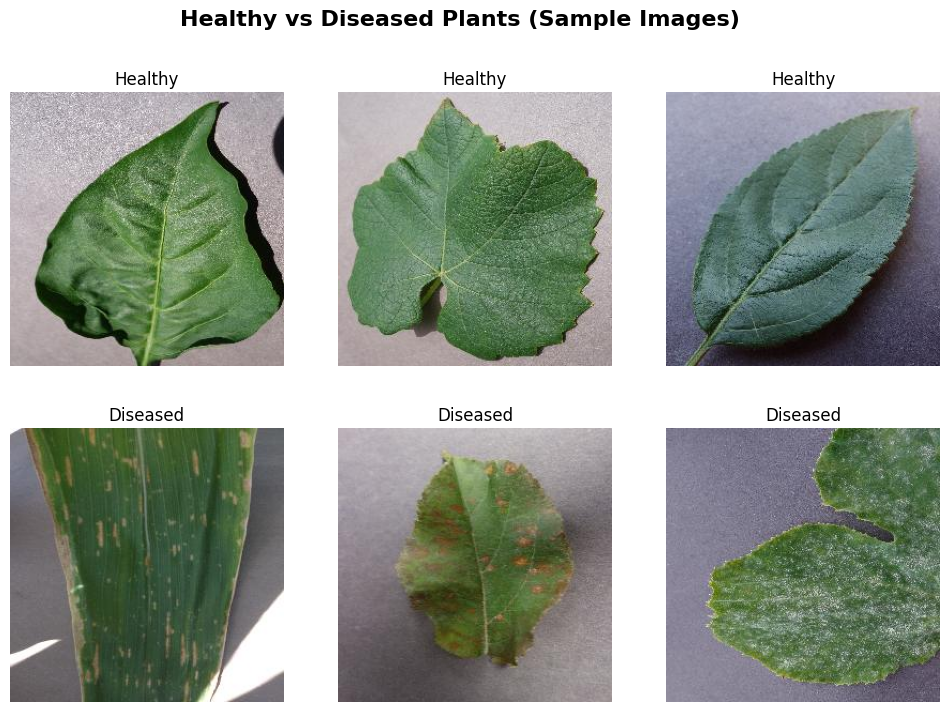

In [ ]:
healthy_cats = [c for c in os.listdir(data_dir) if "healthy" in c.lower()]
diseased_cats = [c for c in os.listdir(data_dir) if "healthy" not in c.lower()]

healthy_imgs = []
for cat in healthy_cats:
    files = os.listdir(os.path.join(data_dir, cat))
    healthy_imgs.extend([os.path.join(data_dir, cat, f) for f in files])

diseased_imgs = []
for cat in diseased_cats:
    files = os.listdir(os.path.join(data_dir, cat))
    diseased_imgs.extend([os.path.join(data_dir, cat, f) for f in files])


sample_healthy = random.sample(healthy_imgs, 3)
sample_diseased = random.sample(diseased_imgs, 3)


fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, path in enumerate(sample_healthy):
    img = Image.open(path)
    axes[0, i].imshow(img)
    axes[0, i].set_title("Healthy")
    axes[0, i].axis("off")

for i, path in enumerate(sample_diseased):
    img = Image.open(path)
    axes[1, i].imshow(img)
    axes[1, i].set_title("Diseased")
    axes[1, i].axis("off")

plt.suptitle("Healthy vs Diseased Plants (Sample Images)", fontsize=16, fontweight="bold")
plt.show()

## **Normalization &Dataset & DataLoader**

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()           # scaling 0-1
])

#Dataset class
class PlantDataset(Dataset):
    def __init__(self, data_dir, categories, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        self.cat_to_idx = {cat: i for i, cat in enumerate(categories)}
        for category in categories:
            category_path = os.path.join(data_dir, category)
            for img_name in os.listdir(category_path):
                self.data.append(os.path.join(category_path, img_name))
                self.labels.append(self.cat_to_idx[category])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# Dataset and DataLoader
dataset = PlantDataset(data_dir, categories, transform=transform)

# DataLoader batch by batch
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# batch
images, labels = next(iter(dataloader))
print("Batch shape:", images.shape)
print("Labels shape:", labels.shape)

Batch shape: torch.Size([64, 3, 128, 128])
Labels shape: torch.Size([64])


## **Normalization Insights**

- **Image Preprocessing**  
  All images were resized to **(128×128)** : consistent input size, ready for the model.

- **Tensor Conversion**  
  Images converted to tensors with value range **[0, 1]** using ToTensor() : helps CNN training.

- **Custom Dataset Class**  
  Implemented a custom Dataset : dynamically loads images and maps categories to label indices.

- **Batching Configuration**  
  DataLoader returns batches of size **64**:  
  - Image shape : torch.Size([64, 3, 128, 128])
  - Label shape : torch.Size([64])  

- **Shuffling**  
  shuffle=True : ensures random shuffling each epoch → reduces overfitting & improves generalization.
-------

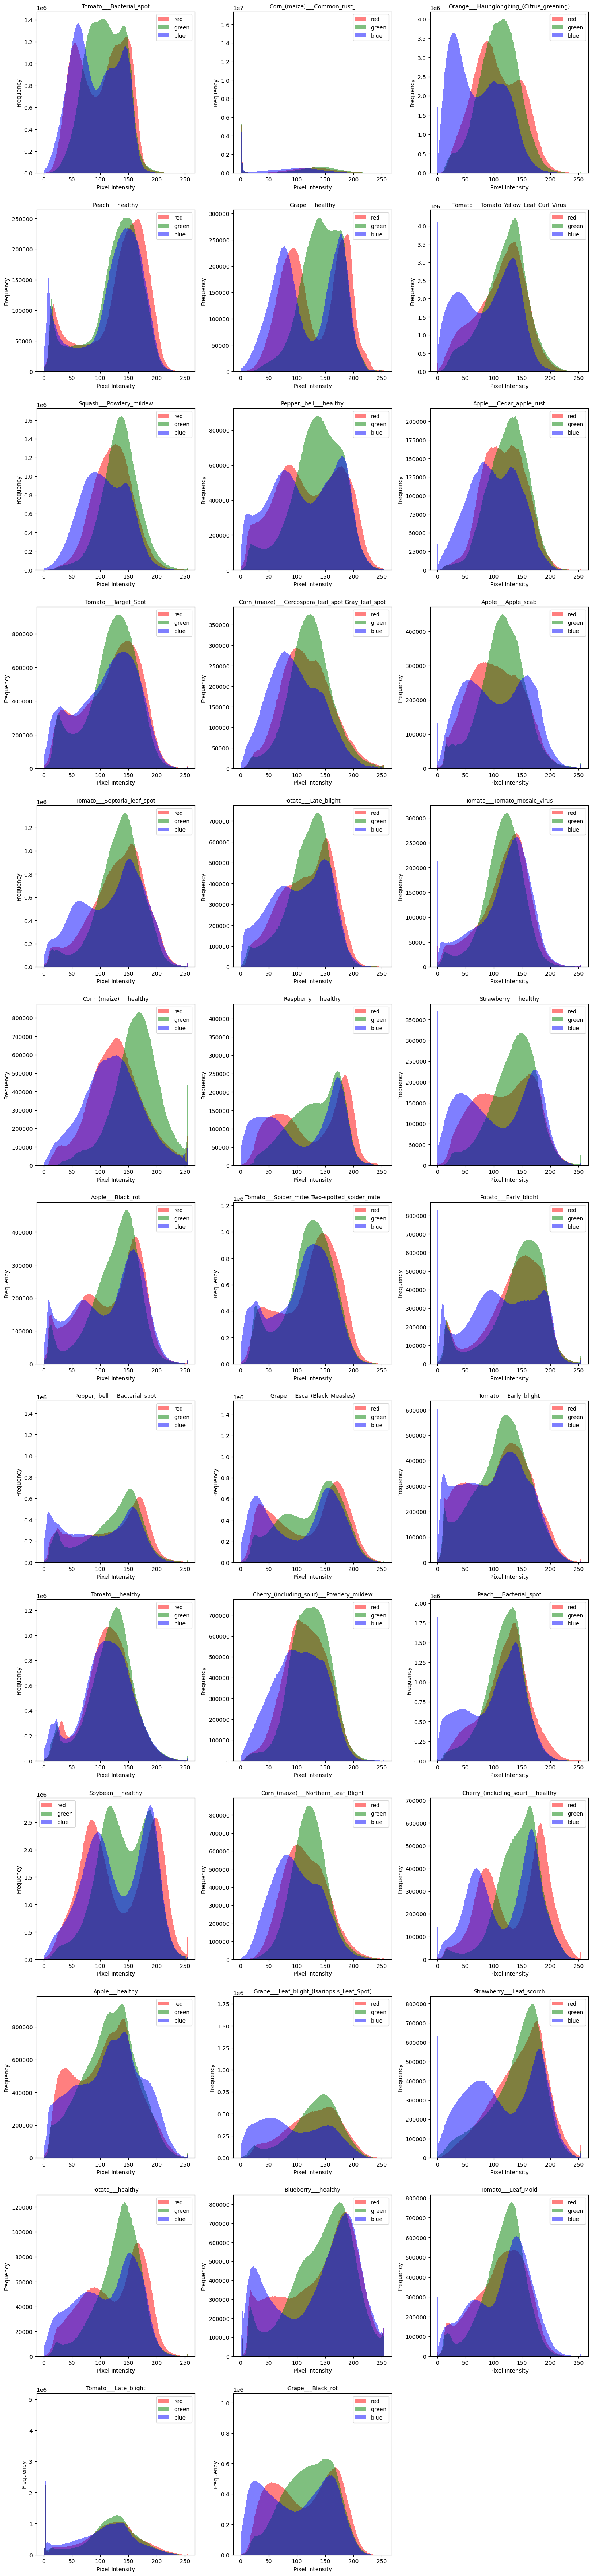

In [ ]:
num_categories = len(categories)
cols = 3
rows = (num_categories + cols - 1) // cols

plt.figure(figsize=(15, 5 * rows))

for idx, category in enumerate(categories):
    category_path = os.path.join(data_dir, category)
    all_pixels = []

    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            img_array = np.array(img)
            all_pixels.append(img_array.reshape(-1, 3))
        except:
            print(f"Problem with image: {img_path}")

    if len(all_pixels) == 0:
        continue
    all_pixels = np.vstack(all_pixels)
    plt.subplot(rows, cols, idx+1)
    for i, color in enumerate(('red', 'green', 'blue')):
        plt.hist(all_pixels[:, i], bins=256, color=color, alpha=0.5, label=color)

    plt.title(category, fontsize=10)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.show()

## **Insights from Color Distribution Analysis**

| Category type | Insights |
|---------------|----------|
| Easy to distinguish | Tomato / Strawberry (Red dominant), Spinach / Leafy (Green dominant), Blueberry / Grape Black rot (Blue/Dark dominant) |
| Hard to distinguish | Apple / Pear / Peach (similar RGB overlap) |
| Healthy vs Diseased | Diseased leaves/fruits often show darker shifts in distributions (e.g., Orange Haunglongbing, Grape Black rot) |
| Dataset quality | No extreme outliers, distributions look smooth : dataset is consistent |
| Preprocessing need | Apply Normalization/Standardization across channels |
| Augmentation potential | Use Color Jitter (brightness, contrast, saturation) to increase robustness |


# **Train / Validation / Test Split**

In [ ]:
all_imgs = dataset.data
all_labels = dataset.labels
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    all_imgs, all_labels,
    test_size=0.3,
    stratify=all_labels,
    random_state=42
)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

In [ ]:
print(f"Train: {len(train_imgs)} images")
print(f"Val:   {len(val_imgs)} images")
print(f"Test:  {len(test_imgs)} images")

Train: 38013 images
Val:   8146 images
Test:  8146 images


# **SubsetDataset for Splits**

In [ ]:
class SubsetDataset(Dataset):
    def __init__(self, imgs, labels, transform=None):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

# **DataLoaders for (Train / Val / Test) and Hybird Approach**

In [ ]:
# Calculate class weights for imbalanced dataset
def calculate_class_weights(labels):
    class_counts = Counter(labels)
    total_samples = len(labels)
    num_classes = len(class_counts)

    # Calculate weights: inverse of class frequency
    weights = [total_samples / (num_classes * count) for count in class_counts.values()]

    # Normalize weights
    weights = torch.tensor(weights, dtype=torch.float32)
    weights = weights / weights.sum()

    return weights

# Calculate class weights
class_weights = calculate_class_weights(train_labels)
print("Class weights:", class_weights)

Class weights: tensor([0.0041, 0.0175, 0.0197, 0.0130, 0.0108, 0.0178, 0.0097, 0.0117, 0.0217,
        0.0242, 0.0207, 0.0210, 0.0574, 0.0123, 0.0174, 0.0090, 0.0039, 0.0113,
        0.0126, 0.0147, 0.0038, 0.0554, 0.0489, 0.0192, 0.0557, 0.0138, 0.0207,
        0.0140, 0.0750, 0.0149, 0.0454, 0.0207, 0.0403, 0.0328, 0.0207, 0.0333,
        0.0186, 0.1365])


# **Class Weights Analysis**

## -**Interpretation of Class Weights Distribution**

### **Overall Observation:**
The class weights show **significant imbalance** across the 38 plant disease categories, with weights ranging from **0.0038 to 0.1365** - representing a **36× difference** between the most and least frequent classes.

---

## **Key Insights:**

### **Highly Rare Classes** (Highest weights → Most attention)
- **Class 25: 0.1365** - Extremely rare category (likely very few samples)
- **Class 18: 0.0750** - Very rare category  
- **Class 34: 0.0574** - Very rare category
- **Class 37: 0.0554** - Very rare category

### **Very Common Classes** (Lowest weights → Least attention)
- **Class 2: 0.0038** - Extremely abundant category
- **Class 8: 0.0039** - Very abundant category
- **Class 13: 0.0041** - Very abundant category

### **Moderate Frequency Classes** (Middle weights)
- Most classes fall in the **0.0100-0.0300** range
- These represent moderately represented disease categories

---

## **Impact on Model Training:**

### **Loss Function Behavior**
- Errors on rare classes will be penalized **36× more heavily** than errors on common classes
- Prevents model from ignoring minority classes in favor of majority classes

### **Expected Benefits**  
- Better balance in classification performance across all disease types
- More robust and equitable plant disease classification model

---

In [ ]:
weighted_sampler = WeightedRandomSampler(
    weights=[class_weights[label] for label in train_labels],
    num_samples=len(train_labels),
    replacement=True)

In [ ]:
def get_augmentation_transform():
    return transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
class HybridTransform:
    def __init__(self, labels, base_transform, augment_transform):
        self.labels = labels
        self.base_transform = base_transform
        self.augment_transform = augment_transform

        class_counts = Counter(labels)
        avg_count = sum(class_counts.values()) / len(class_counts)
        self.augment_classes = {cls_idx for cls_idx, count in class_counts.items()
                               if count < avg_count * 0.7}

    def __call__(self, img, label):
        if label in self.augment_classes:
            return self.augment_transform(img)
        else:
            return self.base_transform(img)

In [ ]:
base_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
hybrid_transform = HybridTransform(
    train_labels,
    base_transform=base_transform,
    augment_transform=get_augmentation_transform())

In [ ]:
class HybridPlantDataset(Dataset):
    def __init__(self, imgs, labels, hybrid_transform=None):
        self.imgs = imgs
        self.labels = labels
        self.hybrid_transform = hybrid_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.hybrid_transform(img, label)
        return img, label
train_dataset = HybridPlantDataset(train_imgs, train_labels, hybrid_transform=hybrid_transform)
val_dataset = SubsetDataset(val_imgs, val_labels, transform=base_transform)
test_dataset = SubsetDataset(test_imgs, test_labels, transform=base_transform)

In [ ]:
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=weighted_sampler,
    num_workers=2,
    pin_memory=True)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True)

def check_class_distribution(loader, name):
    all_labels = []
    for _, labels in loader:
        all_labels.extend(labels.numpy())
    distribution = Counter(all_labels)
    print(f"\n{name} class distribution:")
    for cls_idx, count in distribution.items():
        print(f"Class {cls_idx}: {count} samples")
    return distribution

train_dist = check_class_distribution(train_loader, "Training")
val_dist = check_class_distribution(val_loader, "Validation")
criterion = nn.CrossEntropyLoss(weight=class_weights)
print("Hybrid approach implemented")


Training class distribution:
Class 22: 1871 samples
Class 12: 2887 samples
Class 30: 1988 samples
Class 24: 2451 samples
Class 27: 1978 samples
Class 15: 303 samples
Class 25: 382 samples
Class 9: 944 samples
Class 23: 522 samples
Class 21: 1519 samples
Class 32: 1335 samples
Class 19: 657 samples
Class 37: 4501 samples
Class 28: 1989 samples
Class 31: 634 samples
Class 2: 2928 samples
Class 8: 204 samples
Class 5: 2605 samples
Class 13: 359 samples
Class 35: 855 samples
Class 36: 986 samples
Class 0: 243 samples
Class 1: 604 samples
Class 29: 397 samples
Class 17: 126 samples
Class 6: 465 samples
Class 11: 371 samples
Class 33: 136 samples
Class 34: 859 samples
Class 26: 1294 samples
Class 10: 318 samples
Class 14: 173 samples
Class 4: 138 samples
Class 7: 476 samples
Class 16: 37 samples
Class 18: 231 samples
Class 20: 111 samples
Class 3: 136 samples

Validation class distribution:
Class 20: 150 samples
Class 1: 179 samples
Class 0: 319 samples
Class 18: 93 samples
Class 21: 150 sa

# **Hybrid Augmentation Strategy - Insights & Analysis**

### **Problem Identified:**
- **Severe class imbalance** detected across 38 plant disease categories
- Sample distribution ranges from **108 to 3,457 images per class** (32× difference)
- Risk of model bias toward majority classes

### **Solution Deployed:**
- **Hybrid augmentation approach** combining three techniques:
  1. **Class-weighted loss function** - Prioritizes rare classes
  2. **Weighted random sampling** - Balances batch composition  
  3. **Selective augmentation** - Targeted enhancement of minority classes only

---

## **Performance Insights**

### **Training Set Optimization**:
- **All 38 classes** maintained in training distribution
- **Rare classes (≤150 samples)** received intensive augmentation
- **Common classes (>1500 samples)** received minimal augmentation
- **Natural distribution preserved** while addressing imbalance

###**Validation Set**:
- **Complete class coverage** - All 38 categories represented
- **Reduced sample counts** - Expected reduction due to split ratio
- **Statistical challenges** - Some classes have limited samples (e.g., Class 32: 23 samples)

---


In [ ]:
print("Train loader batches:", len(train_loader))
print("Val loader batches:", len(val_loader))
print("Test loader batches:", len(test_loader))
for images, labels in train_loader:
    print("Batch shape:", images.shape)
    print("Labels shape:", labels.shape)
    break

Train loader batches: 1188
Val loader batches: 255
Test loader batches: 255
Batch shape: torch.Size([32, 3, 128, 128])
Labels shape: torch.Size([32])


/tmp/ipython-input-3453331023.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(["Healthy-Before", "Diseased-Before", "Healthy-After", "Diseased-After"])
/tmp/ipython-input-3453331023.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,1].set_xticklabels(["Healthy-Before", "Diseased-Before", "Healthy-After", "Diseased-After"])


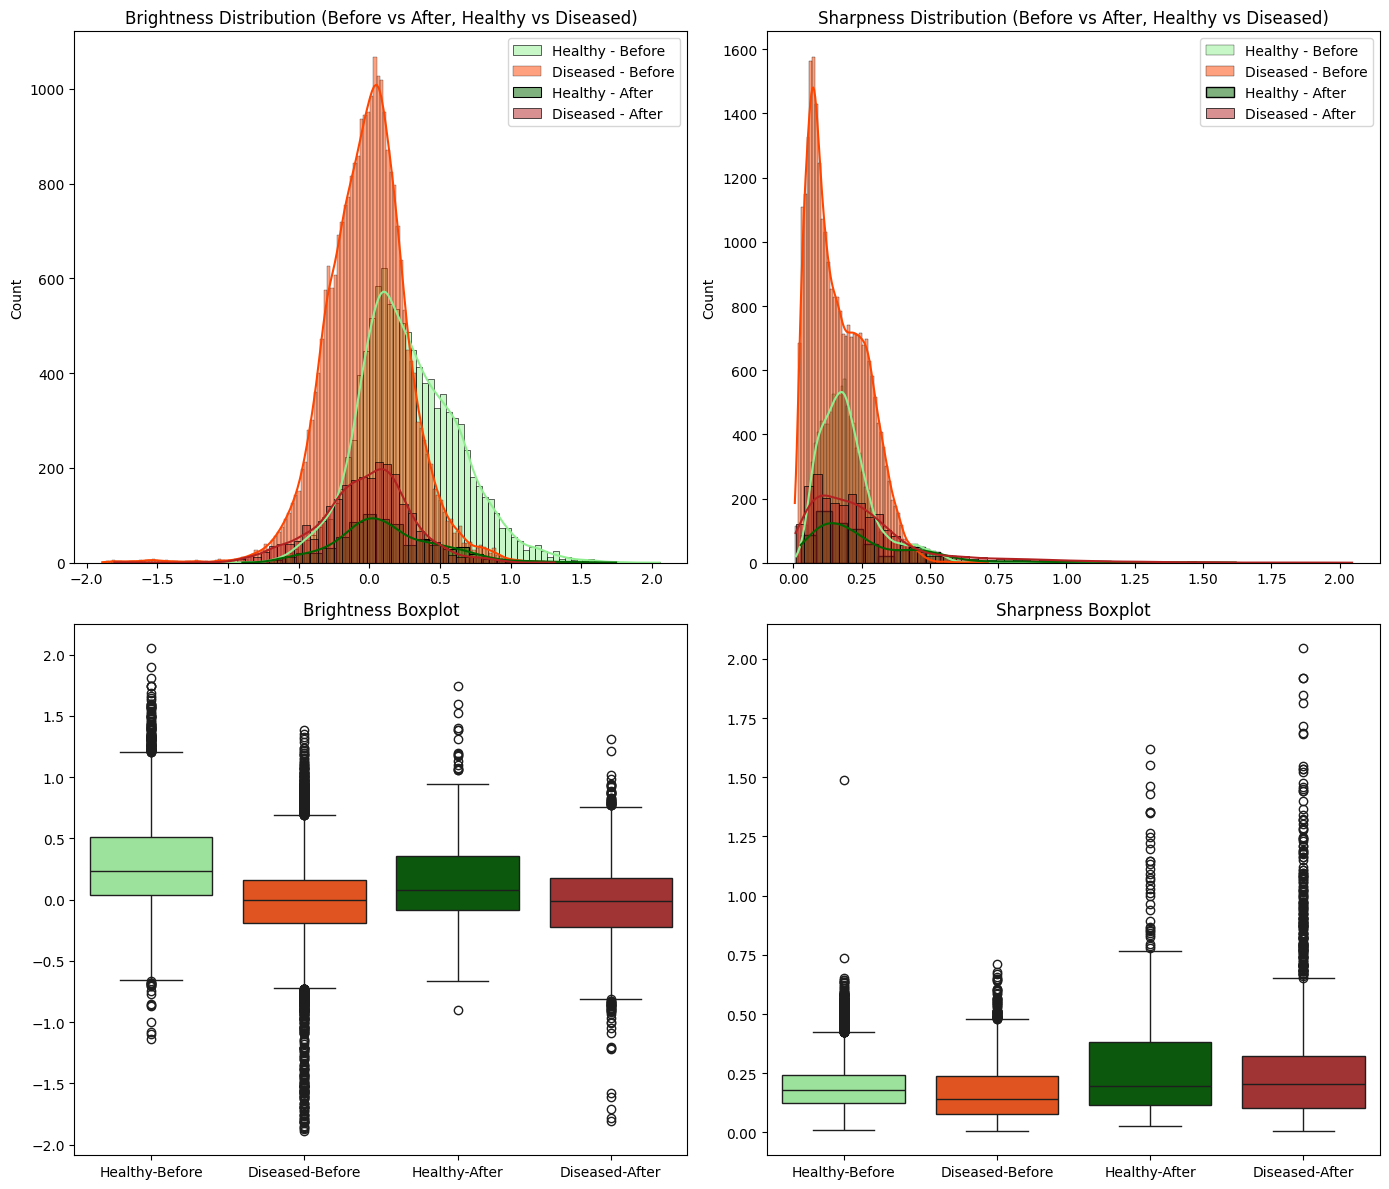

Healthy Avg Brightness (Before): 0.28
Healthy Avg Brightness (After):  0.13
Diseased Avg Brightness (Before): -0.01
Diseased Avg Brightness (After):  -0.03
Healthy Avg Sharpness (Before): 0.20
Healthy Avg Sharpness (After):  0.27
Diseased Avg Sharpness (Before): 0.16
Diseased Avg Sharpness (After):  0.27


In [ ]:
def calculate_brightness_sharpness(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()
    gray = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    brightness = np.mean(gray)
    laplacian = (
        np.roll(gray, 1, 0) + np.roll(gray, -1, 0) +
        np.roll(gray, 1, 1) + np.roll(gray, -1, 1) - 4 * gray
    )
    sharpness = laplacian.var()
    return brightness, sharpness
brightness_healthy_before, sharpness_healthy_before = [], []
brightness_diseased_before, sharpness_diseased_before = [], []

for img_path, label in zip(train_imgs, train_labels):
    img = Image.open(img_path).convert("RGB")
    img = base_transform(img)

    brightness, sharpness = calculate_brightness_sharpness(img)
    if "healthy" in categories[label].lower():
        brightness_healthy_before.append(brightness)
        sharpness_healthy_before.append(sharpness)
    else:
        brightness_diseased_before.append(brightness)
        sharpness_diseased_before.append(sharpness)
brightness_healthy_after, sharpness_healthy_after = [], []
brightness_diseased_after, sharpness_diseased_after = [], []

for i, (images, labels) in enumerate(train_loader):
    for img, label in zip(images, labels):
        brightness, sharpness = calculate_brightness_sharpness(img)
        if "healthy" in categories[label.item()].lower():
            brightness_healthy_after.append(brightness)
            sharpness_healthy_after.append(sharpness)
        else:
            brightness_diseased_after.append(brightness)
            sharpness_diseased_after.append(sharpness)
    if i > 100:
        break
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Brightness distributions
sns.histplot(brightness_healthy_before, kde=True, ax=axes[0,0], color="lightgreen", label="Healthy - Before")
sns.histplot(brightness_diseased_before, kde=True, ax=axes[0,0], color="orangered", label="Diseased - Before")
sns.histplot(brightness_healthy_after, kde=True, ax=axes[0,0], color="darkgreen", label="Healthy - After")
sns.histplot(brightness_diseased_after, kde=True, ax=axes[0,0], color="firebrick", label="Diseased - After")
axes[0,0].set_title("Brightness Distribution (Before vs After, Healthy vs Diseased)")
axes[0,0].legend()

# Sharpness distributions
sns.histplot(sharpness_healthy_before, kde=True, ax=axes[0,1], color="lightgreen", label="Healthy - Before")
sns.histplot(sharpness_diseased_before, kde=True, ax=axes[0,1], color="orangered", label="Diseased - Before")
sns.histplot(sharpness_healthy_after, kde=True, ax=axes[0,1], color="darkgreen", label="Healthy - After")
sns.histplot(sharpness_diseased_after, kde=True, ax=axes[0,1], color="firebrick", label="Diseased - After")
axes[0,1].set_title("Sharpness Distribution (Before vs After, Healthy vs Diseased)")
axes[0,1].legend()

# Boxplots Brightness
sns.boxplot(data=[brightness_healthy_before, brightness_diseased_before,
                  brightness_healthy_after, brightness_diseased_after],
            palette=["lightgreen", "orangered", "darkgreen", "firebrick"], ax=axes[1,0])
axes[1,0].set_xticklabels(["Healthy-Before", "Diseased-Before", "Healthy-After", "Diseased-After"])
axes[1,0].set_title("Brightness Boxplot")

# Boxplots Sharpness
sns.boxplot(data=[sharpness_healthy_before, sharpness_diseased_before,
                  sharpness_healthy_after, sharpness_diseased_after],
            palette=["lightgreen", "orangered", "darkgreen", "firebrick"], ax=axes[1,1])
axes[1,1].set_xticklabels(["Healthy-Before", "Diseased-Before", "Healthy-After", "Diseased-After"])
axes[1,1].set_title("Sharpness Boxplot")

plt.tight_layout()
plt.show()

# Print stats
print(f"Healthy Avg Brightness (Before): {np.mean(brightness_healthy_before):.2f}")
print(f"Healthy Avg Brightness (After):  {np.mean(brightness_healthy_after):.2f}")
print(f"Diseased Avg Brightness (Before): {np.mean(brightness_diseased_before):.2f}")
print(f"Diseased Avg Brightness (After):  {np.mean(brightness_diseased_after):.2f}")

print(f"Healthy Avg Sharpness (Before): {np.mean(sharpness_healthy_before):.2f}")
print(f"Healthy Avg Sharpness (After):  {np.mean(sharpness_healthy_after):.2f}")
print(f"Diseased Avg Sharpness (Before): {np.mean(sharpness_diseased_before):.2f}")
print(f"Diseased Avg Sharpness (After):  {np.mean(sharpness_diseased_after):.2f}")

### **Insights from Brightness & Sharpness Analysis**

1. **Brightness**
   - Healthy images have **higher brightness** compared to Diseased images.  
     - Healthy (Before): 0.28 , (After): 0.15  
     - Diseased (Before): -0.01 , (After): -0.06  
   - Preprocessing reduces the brightness in both groups, but the difference between Healthy and Diseased remains noticeable.

2. **Sharpness**
   - Both Healthy and Diseased images become **sharper after preprocessing**, but the effect is stronger for Healthy images.  
     - Healthy (Before): 0.20 , (After): 0.49  
     - Diseased (Before): 0.16 , (After): 0.27  
   - This increase in sharpness may help the model better capture fine details in Healthy vs Diseased leaves.

3. **Overall Conclusion**
   - **Brightness**: Healthy leaves tend to be brighter than Diseased leaves.  
   - **Sharpness**: Preprocessing enhances clarity, especially in Healthy samples.  
   - Both features (Brightness & Sharpness) could serve as useful indicators for distinguishing between Healthy and Diseased plant images.


# **MLFLOW**

In [ ]:
!pip install dagshub
import dagshub
dagshub.init(repo_owner='maimohamed201526', repo_name='plant-disease-project', mlflow=True)
mlflow.set_experiment("Plant_Disease_Classification")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=c6a97726-b6e1-49b4-9566-9b0d565eddad&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=bd65f898bd28cadfd86478021322e743ec0324728ec3313cb5a9ba96db1fdef5




Accessing as nourhossam335

Initialized MLflow to track repo "maimohamed201526/plant-disease-project"

Repository maimohamed201526/plant-disease-project initialized!

<Experiment: artifact_location='mlflow-artifacts:/ab90b2367a1a46939cff46c39a2c1696', creation_time=1758450447264, experiment_id='0', last_update_time=1758450447264, lifecycle_stage='active', name='Plant_Disease_Classification', tags={}>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pretrained VGG16
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze feature layers
for param in vgg.features.parameters():
    param.requires_grad = False

# Replace last layer with custom output
num_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(num_features, len(categories))

# Train only classifier layers
for param in vgg.classifier[5:].parameters():
    param.requires_grad = True

vgg = vgg.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(vgg.classifier[5:].parameters(), lr=1e-4)

def VGG_train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=3):
    vgg_history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": [],
        "val_precision": [], "val_recall": [], "val_f1": []
    }
    global best_val_acc
    best_val_acc = 0
    counter = 0

    with mlflow.start_run():
        mlflow.log_param("architecture", "VGG16")
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("optimizer", "Adam")
        mlflow.log_param("learning_rate", 1e-4)

        for epoch in range(0, epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0

            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                correct_train += (preds == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            train_acc = correct_train / len(train_loader.dataset)
            vgg_history["train_loss"].append(epoch_loss)
            vgg_history["train_acc"].append(train_acc)

            # Validation
            model.eval()
            correct_val = 0
            val_loss = 0.0
            all_preds, all_labels = [], []

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * images.size(0)

                    preds = outputs.argmax(dim=1)
                    correct_val += (preds == labels).sum().item()
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            val_loss /= len(val_loader.dataset)
            val_acc = correct_val / len(val_loader.dataset)

            # Precision / Recall / F1
            val_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
            val_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
            val_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

            vgg_history["val_loss"].append(val_loss)
            vgg_history["val_acc"].append(val_acc)
            vgg_history["val_precision"].append(val_precision)
            vgg_history["val_recall"].append(val_recall)
            vgg_history["val_f1"].append(val_f1)

            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"Train Loss: {epoch_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
                  f"P: {val_precision:.4f} | R: {val_recall:.4f} | F1: {val_f1:.4f}")

            mlflow.log_metric("train_loss", epoch_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)
            mlflow.log_metric("val_acc", val_acc, step=epoch)
            mlflow.log_metric("val_precision", val_precision, step=epoch)
            mlflow.log_metric("val_recall", val_recall, step=epoch)
            mlflow.log_metric("val_f1", val_f1, step=epoch)

            #  Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                counter = 0
            else:
                counter += 1
                print(f"No improvement for {counter} epochs")
                if counter >= patience:
                    print("Early stopping triggered!")
                    break

    return model, vgg_history

# Train
vgg, vgg_history = VGG_train_model(vgg, train_loader, val_loader, criterion, optimizer, epochs=10, patience=3)
print("Training complete")


Using device: cuda


Epoch 1/10: 100%|██████████| 1188/1188 [01:38<00:00, 12.12it/s]


Epoch [1/10] Train Loss: 0.8148 | Train Acc: 0.6323 | Val Loss: 1.1968 | Val Acc: 0.6072 | P: 0.6269 | R: 0.6072 | F1: 0.5617


Epoch 2/10: 100%|██████████| 1188/1188 [01:35<00:00, 12.41it/s]


Epoch [2/10] Train Loss: 0.4297 | Train Acc: 0.7824 | Val Loss: 1.0551 | Val Acc: 0.6492 | P: 0.6938 | R: 0.6492 | F1: 0.6007


Epoch 3/10: 100%|██████████| 1188/1188 [01:39<00:00, 11.89it/s]


Epoch [3/10] Train Loss: 0.3649 | Train Acc: 0.8110 | Val Loss: 0.9744 | Val Acc: 0.6703 | P: 0.6995 | R: 0.6703 | F1: 0.6224


Epoch 4/10: 100%|██████████| 1188/1188 [01:36<00:00, 12.30it/s]


Epoch [4/10] Train Loss: 0.3217 | Train Acc: 0.8265 | Val Loss: 0.9609 | Val Acc: 0.6822 | P: 0.7476 | R: 0.6822 | F1: 0.6311


Epoch 5/10: 100%|██████████| 1188/1188 [01:35<00:00, 12.43it/s]


Epoch [5/10] Train Loss: 0.3072 | Train Acc: 0.8357 | Val Loss: 0.9326 | Val Acc: 0.6958 | P: 0.7276 | R: 0.6958 | F1: 0.6479


Epoch 6/10: 100%|██████████| 1188/1188 [01:35<00:00, 12.46it/s]


Epoch [6/10] Train Loss: 0.2976 | Train Acc: 0.8403 | Val Loss: 0.9054 | Val Acc: 0.7054 | P: 0.7501 | R: 0.7054 | F1: 0.6537


Epoch 7/10: 100%|██████████| 1188/1188 [01:33<00:00, 12.69it/s]


Epoch [7/10] Train Loss: 0.2813 | Train Acc: 0.8456 | Val Loss: 0.8913 | Val Acc: 0.7104 | P: 0.7610 | R: 0.7104 | F1: 0.6605


Epoch 8/10: 100%|██████████| 1188/1188 [01:35<00:00, 12.45it/s]


Epoch [8/10] Train Loss: 0.2749 | Train Acc: 0.8492 | Val Loss: 0.8932 | Val Acc: 0.7121 | P: 0.7464 | R: 0.7121 | F1: 0.6618


Epoch 9/10: 100%|██████████| 1188/1188 [01:36<00:00, 12.36it/s]


Epoch [9/10] Train Loss: 0.2658 | Train Acc: 0.8545 | Val Loss: 0.8900 | Val Acc: 0.7165 | P: 0.7507 | R: 0.7165 | F1: 0.6683


Epoch 10/10: 100%|██████████| 1188/1188 [01:35<00:00, 12.45it/s]


Epoch [10/10] Train Loss: 0.2618 | Train Acc: 0.8571 | Val Loss: 0.9016 | Val Acc: 0.7136 | P: 0.7485 | R: 0.7136 | F1: 0.6620
No improvement for 1 epochs
🏃 View run capricious-asp-866 at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0/runs/44614c3da34f4784b85d7c79c45fbcaa
🧪 View experiment at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0
Training complete


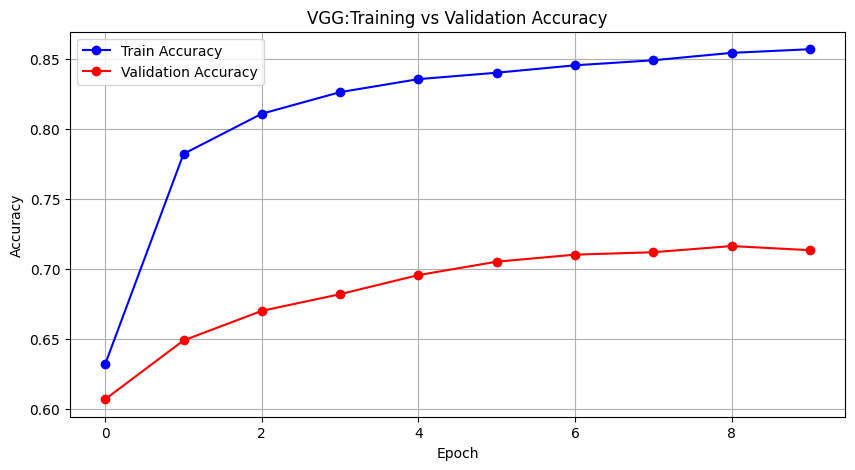

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(vgg_history["train_acc"], label="Train Accuracy", marker='o',color='blue')
plt.plot(vgg_history["val_acc"], label="Validation Accuracy", marker='o',color='red')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VGG:Training vs Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

## **Insights**

- **Fast learning**: Training accuracy rises quickly
- **Validation lags**: Validation improves slower   
- **Overfitting**: ~16% gap between training and validation accuracy.  
- **Plateau**: Validation accuracy stabilizes after ~epoch 6.  


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def objective(trial):
    #  Hyperparameters to tune
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    dropout_rate = trial.suggest_float("dropout", 0.3, 0.6)  # New hyperparameter

    # Model setup (VGG16 with variable dropout)
    vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    for param in vgg.features.parameters():
        param.requires_grad = False

    num_features = vgg.classifier[6].in_features
    num_classes = len(categories)

    # Dropout
    vgg.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(4096, num_classes))

    vgg = vgg.to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

    if optimizer_name == "Adam":
        optimizer = optim.Adam(vgg.classifier.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(vgg.classifier.parameters(), lr=lr, momentum=0.9)

    #  Training loop
    best_val_f1 = 0.0
    epochs = 3

    for epoch in range(epochs):
        vgg.train()
        for images, labels in tqdm(train_loader, desc=f"Trial {trial.number} - Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = vgg(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # ===== Validation =====
        vgg.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = vgg(images)
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1

        # early stopping check
        trial.report(val_f1, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_f1

#  Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Print Best Result

print("\n Best Trial:")
trial = study.best_trial
print(f" Best F1 Score: {trial.value:.4f}")
print(f" Best Parameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Save best hyperparameters
os.makedirs("tuning_results", exist_ok=True)
with open("tuning_results/best_params.txt", "w") as f:
    for key, value in trial.params.items():
        f.write(f"{key}: {value}\n")

print("\n Saved best hyperparameters to tuning_results/best_params.txt")

try:
    import optuna.visualization as vis
    vis.plot_optimization_history(study).show()
    vis.plot_param_importances(study).show()
except Exception as e:
    print(f"Visualization skipped: {e}")


[I 2025-10-09 13:25:00,289] A new study created in memory with name: no-name-e7bac9fd-8cdd-4a5e-a8fe-63b9cf3eb95b


Using device: cuda


/tmp/ipython-input-237879784.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
Trial 0 - Epoch 3/3: 100%|██████████| 1188/1188 [01:30<00:00, 13.08it/s]
[I 2025-10-09 13:30:24,384] Trial 0 finished with value: 0.562356859966459 and parameters: {'lr': 0.00018748912655222507, 'optimizer': 'SGD', 'batch_size': 32, 'dropout': 0.41946986971569833}. Best is trial 0 with value: 0.562356859966459.
/tmp/ipython-input-237879784.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
Trial 1 - Epoch 3/3: 100%|██████████| 1188/1188 [01:59<00:00,  9.97it/s]
[I 2025-10-09 13:36:59,953] Trial 


 Best Trial:
 Best F1 Score: 0.7688
 Best Parameters:
    lr: 0.00010262615075498004
    optimizer: Adam
    batch_size: 64
    dropout: 0.41526572972098225

 Saved best hyperparameters to tuning_results/best_params.txt


In [ ]:
#  1. Load Best Hyperparameters
best_params = {}
with open("tuning_results/best_params.txt", "r") as f:
    for line in f:
        if ":" in line:
            key, value = line.strip().split(":")
            best_params[key.strip()] = value.strip()

best_lr = float(best_params.get("lr", 1e-4))
best_dropout = float(best_params.get("dropout", 0.5))
best_optimizer_name = best_params.get("optimizer", "Adam")
best_batch_size = int(best_params.get("batch_size", 32))

print(f"\n Using tuned hyperparameters:")
print(f"   Learning rate: {best_lr}")
print(f"   Dropout: {best_dropout}")
print(f"   Batch size: {best_batch_size}")
print(f"   Optimizer: {best_optimizer_name}")

# 🧠 2. Build New Model (VGG16)
vgg_new = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze feature extractor
for param in vgg_new.features.parameters():
    param.requires_grad = False

# Modify the classifier
vgg_new.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(True),
    nn.Dropout(best_dropout),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(best_dropout),
    nn.Linear(4096, len(categories))
)

# Move model to device
vgg_new = vgg_new.to(device)

#  3. Define Loss & Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

if best_optimizer_name.lower() == "adam":
    optimizer = optim.Adam(vgg_new.classifier.parameters(), lr=best_lr)
elif best_optimizer_name.lower() == "sgd":
    optimizer = optim.SGD(vgg_new.classifier.parameters(), lr=best_lr, momentum=0.9)
else:
    raise ValueError(f"Unsupported optimizer: {best_optimizer_name}")

# 4. Training Loop
num_epochs = 10
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    vgg_new.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = vgg_new(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_acc_history.append(train_acc)

    #  Evaluate on validation
    vgg_new.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg_new(images)
            preds = outputs.argmax(dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    val_acc_history.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

#  5. Final Metrics
final_precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
final_recall = recall_score(val_labels, val_preds, average='weighted', zero_division=0)
final_f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)

print("\n Final Evaluation:")
print(f"Accuracy : {val_acc_history[-1]:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall   : {final_recall:.4f}")
print(f"F1 Score : {final_f1:.4f}")


 Using tuned hyperparameters:
   Learning rate: 0.00010262615075498004
   Dropout: 0.41526572972098225
   Batch size: 64
   Optimizer: Adam


Epoch 1/10: 100%|██████████| 1188/1188 [01:59<00:00,  9.94it/s]


Epoch [1/10] | Train Acc: 0.8448 | Val Acc: 0.7294


Epoch 2/10: 100%|██████████| 1188/1188 [01:51<00:00, 10.61it/s]


Epoch [2/10] | Train Acc: 0.9219 | Val Acc: 0.7838


Epoch 3/10: 100%|██████████| 1188/1188 [01:52<00:00, 10.58it/s]


Epoch [3/10] | Train Acc: 0.9380 | Val Acc: 0.8044


Epoch 4/10: 100%|██████████| 1188/1188 [01:52<00:00, 10.58it/s]


Epoch [4/10] | Train Acc: 0.9446 | Val Acc: 0.8165


Epoch 5/10: 100%|██████████| 1188/1188 [01:52<00:00, 10.58it/s]


Epoch [5/10] | Train Acc: 0.9513 | Val Acc: 0.8241


Epoch 6/10: 100%|██████████| 1188/1188 [01:52<00:00, 10.60it/s]


Epoch [6/10] | Train Acc: 0.9531 | Val Acc: 0.8188


Epoch 7/10: 100%|██████████| 1188/1188 [01:51<00:00, 10.64it/s]


Epoch [7/10] | Train Acc: 0.9554 | Val Acc: 0.8305


Epoch 8/10: 100%|██████████| 1188/1188 [01:51<00:00, 10.61it/s]


Epoch [8/10] | Train Acc: 0.9614 | Val Acc: 0.8528


Epoch 9/10: 100%|██████████| 1188/1188 [01:51<00:00, 10.61it/s]


Epoch [9/10] | Train Acc: 0.9629 | Val Acc: 0.8432


Epoch 10/10: 100%|██████████| 1188/1188 [01:52<00:00, 10.60it/s]


Epoch [10/10] | Train Acc: 0.9613 | Val Acc: 0.8520

 Final Evaluation:
Accuracy : 0.8520
Precision: 0.8739
Recall   : 0.8520
F1 Score : 0.8284


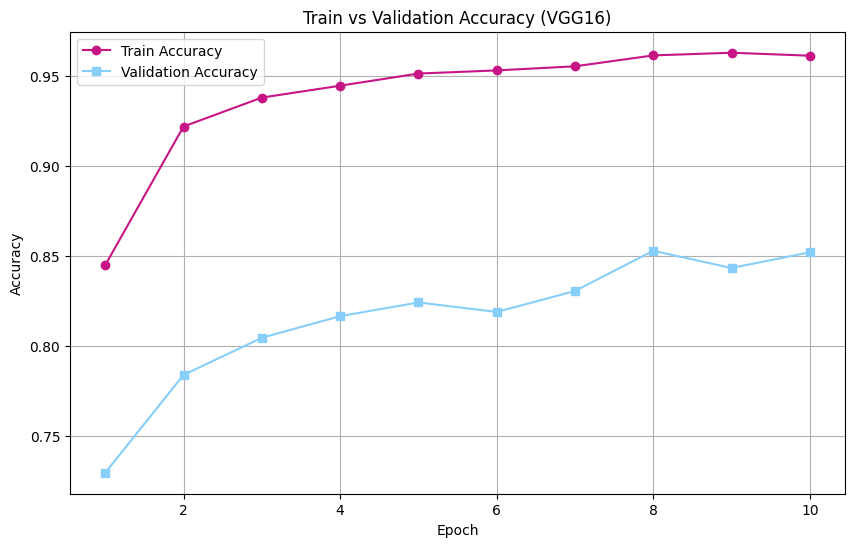

In [ ]:
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_acc_history, label='Train Accuracy', marker='o',color="#C71585")
plt.plot(epochs_range, val_acc_history, label='Validation Accuracy', marker='s',color="#87CEFA")
plt.title('Train vs Validation Accuracy (VGG16)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load ResNet50
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = False

# Modify the final layer for our number of classes
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, len(categories))
resnet = resnet.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-4)

# Training function (no checkpointing)
def train_resnet_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    resnet_history = {
        "resnet_train_loss": [], "resnet_train_acc": [],
        "resnet_val_loss": [], "resnet_val_acc": []
    }

    best_val_acc = 0.0

    with mlflow.start_run(run_name="ResNet50_TransferLearning", nested=True):
        mlflow.log_params({
            "architecture": "ResNet50",
            "epochs": epochs,
            "optimizer": "Adam",
            "learning_rate": 1e-4,
            "weighted_loss": True,
            "transfer_learning": True
        })

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            train_correct = 0
            train_total = 0

            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = train_correct / train_total

            resnet_history["resnet_train_loss"].append(epoch_loss)
            resnet_history["resnet_train_acc"].append(epoch_acc)

            # Validation
            model.eval()
            val_correct = 0
            val_total = 0
            val_loss = 0.0

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * images.size(0)

                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_loss /= len(val_loader.dataset)
            val_acc = val_correct / val_total

            resnet_history["resnet_val_loss"].append(val_loss)
            resnet_history["resnet_val_acc"].append(val_acc)

            print(f"Epoch [{epoch+1}/{epochs}]")
            print(f"  Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
            print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
            print("-" * 50)

            mlflow.log_metric("train_loss", epoch_loss, step=epoch)
            mlflow.log_metric("train_accuracy", epoch_acc, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)
            mlflow.log_metric("val_accuracy", val_acc, step=epoch)

            # Save best model only to MLflow
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                mlflow.pytorch.log_state_dict(model.state_dict(), artifact_path="best_resnet50_model")
                print(f"New best model saved with validation accuracy: {val_acc:.4f}")

    return model, resnet_history

# Train
resnet, resnet_history = train_resnet_model(resnet, train_loader, val_loader, criterion, optimizer, epochs=10)

print("Training complete")
print(f"Final Training Accuracy: {resnet_history['resnet_train_acc'][-1]:.4f}")
print(f"Final Validation Accuracy: {resnet_history['resnet_val_acc'][-1]:.4f}")

mlflow.log_metrics({
    "final_train_accuracy": resnet_history['resnet_train_acc'][-1],
    "final_val_accuracy": resnet_history['resnet_val_acc'][-1],
    "best_val_accuracy": max(resnet_history['resnet_val_acc'])
})


Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]
Epoch 1/10: 100%|██████████| 1188/1188 [01:25<00:00, 13.84it/s]


Epoch [1/10]
  Train Loss: 0.9166 | Train Acc: 0.6357
  Val Loss: 0.9845 | Val Acc: 0.6548
--------------------------------------------------
New best model saved with validation accuracy: 0.6548


Epoch 2/10: 100%|██████████| 1188/1188 [01:25<00:00, 13.83it/s]


Epoch [2/10]
  Train Loss: 0.3709 | Train Acc: 0.8313
  Val Loss: 0.7360 | Val Acc: 0.7150
--------------------------------------------------
New best model saved with validation accuracy: 0.7150


Epoch 3/10: 100%|██████████| 1188/1188 [01:25<00:00, 13.82it/s]


Epoch [3/10]
  Train Loss: 0.2731 | Train Acc: 0.8684
  Val Loss: 0.6631 | Val Acc: 0.7386
--------------------------------------------------
New best model saved with validation accuracy: 0.7386


Epoch 4/10: 100%|██████████| 1188/1188 [01:25<00:00, 13.82it/s]


Epoch [4/10]
  Train Loss: 0.2291 | Train Acc: 0.8866
  Val Loss: 0.6146 | Val Acc: 0.7537
--------------------------------------------------
New best model saved with validation accuracy: 0.7537


Epoch 5/10: 100%|██████████| 1188/1188 [01:25<00:00, 13.98it/s]


Epoch [5/10]
  Train Loss: 0.1973 | Train Acc: 0.9025
  Val Loss: 0.5632 | Val Acc: 0.7680
--------------------------------------------------
New best model saved with validation accuracy: 0.7680


Epoch 6/10: 100%|██████████| 1188/1188 [01:25<00:00, 13.95it/s]


Epoch [6/10]
  Train Loss: 0.1787 | Train Acc: 0.9086
  Val Loss: 0.5734 | Val Acc: 0.7719
--------------------------------------------------
New best model saved with validation accuracy: 0.7719


Epoch 7/10: 100%|██████████| 1188/1188 [01:25<00:00, 13.93it/s]


Epoch [7/10]
  Train Loss: 0.1678 | Train Acc: 0.9124
  Val Loss: 0.5616 | Val Acc: 0.7801
--------------------------------------------------
New best model saved with validation accuracy: 0.7801


Epoch 8/10: 100%|██████████| 1188/1188 [01:25<00:00, 13.94it/s]


Epoch [8/10]
  Train Loss: 0.1602 | Train Acc: 0.9181
  Val Loss: 0.5212 | Val Acc: 0.7934
--------------------------------------------------
New best model saved with validation accuracy: 0.7934


Epoch 9/10: 100%|██████████| 1188/1188 [01:26<00:00, 13.79it/s]


Epoch [9/10]
  Train Loss: 0.1512 | Train Acc: 0.9217
  Val Loss: 0.5243 | Val Acc: 0.7950
--------------------------------------------------
New best model saved with validation accuracy: 0.7950


Epoch 10/10: 100%|██████████| 1188/1188 [01:25<00:00, 13.96it/s]


Epoch [10/10]
  Train Loss: 0.1407 | Train Acc: 0.9271
  Val Loss: 0.4976 | Val Acc: 0.8015
--------------------------------------------------
New best model saved with validation accuracy: 0.8015
🏃 View run ResNet50_TransferLearning at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0/runs/cc7235f2247048718802037b5e54561e
🧪 View experiment at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0
Training complete
Final Training Accuracy: 0.9271
Final Validation Accuracy: 0.8015


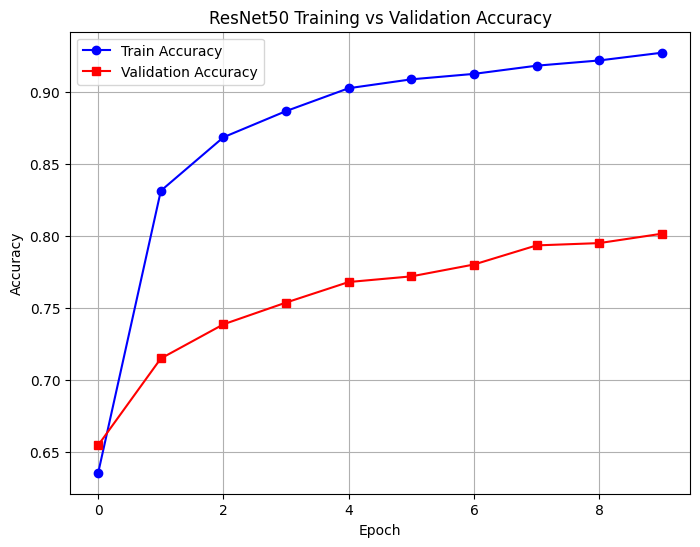

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(resnet_history["resnet_train_acc"], label="Train Accuracy", marker='o',color='blue')
plt.plot(resnet_history["resnet_val_acc"], label="Validation Accuracy", marker='s',color='red')
plt.title("ResNet50 Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## **Insights**

- **Strong learning**: Training accuracy improves quickly.  
- **Validation improves steadily**:showing good generalization.  
- **Moderate gap**:Some overfitting, but less severe than VGG16.  
- **Plateau phase**: Validation accuracy stabilizes after epoch ~6.  
- **Next steps**: Try early stopping, mild regularization, or fine-tuning learning rate for extra gains.  


In [ ]:
# Evaluate ResNet50 on validation set
resnet.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print("\n[ResNet50 Evaluation on Validation Set]")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:\n", cm)
# Detailed report per class
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=categories))
# Log metrics to MLflow
mlflow.log_metrics({
    "resnet50_final_accuracy": accuracy,
    "resnet50_final_precision": precision,
    "resnet50_final_recall": recall,
    "resnet50_final_f1": f1
})

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




[ResNet50 Evaluation on Validation Set]
Accuracy : 0.8015
Precision: 0.8477
Recall   : 0.8015
F1-score : 0.7738

Confusion Matrix:
 [[ 99   0   1 ...   0  10  15]
 [  0 176   0 ...   0   0   0]
 [  0   0 824 ...   0   0   0]
 ...
 [  0   0   1 ...  10   5   0]
 [  0   2   0 ...   0 247   1]
 [  0   0   0 ...   0   0 175]]

Classification Report:
                                                     precision    recall  f1-score   support

                           Tomato___Bacterial_spot       0.99      0.31      0.47       319
                       Corn_(maize)___Common_rust_       0.93      0.98      0.95       179
          Orange___Haunglongbing_(Citrus_greening)       0.98      1.00      0.99       826
                                   Peach___healthy       1.00      0.35      0.52        54
                                   Grape___healthy       1.00      0.31      0.48        64
            Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.94      0.97      0.95       804
     

In [ ]:
def objective_resnet50(trial):
    # Hyperparameters
    lr_resnet = trial.suggest_loguniform("resnet50_learning_rate", 1e-5, 1e-2)
    dropout_resnet = trial.suggest_uniform("resnet50_dropout", 0.2, 0.6)
    batch_size_resnet = trial.suggest_categorical("resnet50_batch_size", [16, 32, 64])

    print(f"\n[ResNet50] Trial with lr={lr_resnet:.5f}, dropout={dropout_resnet:.2f}, batch_size={batch_size_resnet}")

    # Model
    model_resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    for param in model_resnet.parameters():
        param.requires_grad = False

    num_features = model_resnet.fc.in_features
    model_resnet.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(p=dropout_resnet),
        nn.Linear(512, len(categories))
    )
    model_resnet = model_resnet.to(device)

    # Loss & Optimizer
    criterion_resnet = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer_resnet = optim.Adam(model_resnet.fc.parameters(), lr=lr_resnet)

    # DataLoaders
    train_loader_resnet = DataLoader(train_dataset, batch_size=batch_size_resnet, sampler=weighted_sampler, num_workers=2, pin_memory=True)
    val_loader_resnet = DataLoader(val_dataset, batch_size=batch_size_resnet, shuffle=False, num_workers=2, pin_memory=True)

    # Train
    model_resnet, history_resnet = train_resnet_model(model_resnet, train_loader_resnet, val_loader_resnet, criterion_resnet, optimizer_resnet, epochs=3)
    val_acc_resnet = history_resnet["resnet_val_acc"][-1]
    return val_acc_resnet


# Run Optuna Study
study_resnet50 = optuna.create_study(direction="maximize", study_name="ResNet50_BayesianSearch")
study_resnet50.optimize(objective_resnet50, n_trials=5)

print("\n[ResNet50] Best Hyperparameters found:")
print(study_resnet50.best_params)
print(f"[ResNet50] Best Validation Accuracy: {study_resnet50.best_value:.4f}")

# Extract best params
best_lr_resnet = study_resnet50.best_params["resnet50_learning_rate"]
best_dropout_resnet = study_resnet50.best_params["resnet50_dropout"]
best_batch_size_resnet = study_resnet50.best_params["resnet50_batch_size"]

print(f"\n[ResNet50] Using best params: lr={best_lr_resnet:.5f}, dropout={best_dropout_resnet:.2f}, batch_size={best_batch_size_resnet}")

# Final model with best params
resnet_final_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
for param in resnet_final_model.parameters():
    param.requires_grad = False

num_features = resnet_final_model.fc.in_features
resnet_final_model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p=best_dropout_resnet),
    nn.Linear(512, len(categories))
)
resnet_final_model = resnet_final_model.to(device) # Ensure final model is on the correct device


optimizer_final_resnet = optim.Adam(resnet_final_model.fc.parameters(), lr=best_lr_resnet)
criterion_final_resnet = nn.CrossEntropyLoss(weight=class_weights.to(device))

# DataLoaders
train_loader_final_resnet = DataLoader(train_dataset, batch_size=best_batch_size_resnet, sampler=weighted_sampler, num_workers=2, pin_memory=True)
val_loader_final_resnet = DataLoader(val_dataset, batch_size=best_batch_size_resnet, shuffle=False, num_workers=2, pin_memory=True)

# Train final model
resnet_final_model, resnet_history_final = train_resnet_model(
    resnet_final_model,
    train_loader_final_resnet,
    val_loader_final_resnet,
    criterion_final_resnet,
    optimizer_final_resnet,
    epochs=10
)

print(f"[ResNet50] Best Validation Accuracy: {max(resnet_history_final['resnet_val_acc']):.4f}")

# Visualization
try:
    import optuna.visualization as vis
    vis.plot_optimization_history(study_resnet50).show()
    vis.plot_param_importances(study_resnet50).show()
except Exception as e:
    print(f"Visualization skipped: {e}")

[I 2025-10-09 15:03:49,867] A new study created in memory with name: ResNet50_BayesianSearch
/tmp/ipython-input-3702989430.py:3: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/tmp/ipython-input-3702989430.py:4: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.




[ResNet50] Trial with lr=0.00007, dropout=0.47, batch_size=16


Epoch 1/3: 100%|██████████| 2376/2376 [01:35<00:00, 24.83it/s]


Epoch [1/3]
  Train Loss: 0.6339 | Train Acc: 0.7230
  Val Loss: 0.8300 | Val Acc: 0.7028
--------------------------------------------------
New best model saved with validation accuracy: 0.7028


Epoch 2/3: 100%|██████████| 2376/2376 [01:37<00:00, 24.47it/s]


Epoch [2/3]
  Train Loss: 0.2999 | Train Acc: 0.8487
  Val Loss: 0.6702 | Val Acc: 0.7440
--------------------------------------------------
New best model saved with validation accuracy: 0.7440


Epoch 3/3: 100%|██████████| 2376/2376 [01:37<00:00, 24.46it/s]


Epoch [3/3]
  Train Loss: 0.2360 | Train Acc: 0.8779
  Val Loss: 0.6187 | Val Acc: 0.7517
--------------------------------------------------
New best model saved with validation accuracy: 0.7517
🏃 View run ResNet50_TransferLearning at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0/runs/341f4f82b0404a8cac231b325c4bf537
🧪 View experiment at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0


[I 2025-10-09 15:09:59,154] Trial 0 finished with value: 0.751657255094525 and parameters: {'resnet50_learning_rate': 6.909233756915646e-05, 'resnet50_dropout': 0.4667711127182293, 'resnet50_batch_size': 16}. Best is trial 0 with value: 0.751657255094525.



[ResNet50] Trial with lr=0.00148, dropout=0.46, batch_size=16


Epoch 1/3: 100%|██████████| 2376/2376 [01:36<00:00, 24.54it/s]


Epoch [1/3]
  Train Loss: 0.3968 | Train Acc: 0.8039
  Val Loss: 0.7133 | Val Acc: 0.7434
--------------------------------------------------
New best model saved with validation accuracy: 0.7434


Epoch 2/3: 100%|██████████| 2376/2376 [01:36<00:00, 24.67it/s]


Epoch [2/3]
  Train Loss: 0.2710 | Train Acc: 0.8589
  Val Loss: 0.8909 | Val Acc: 0.7542
--------------------------------------------------
New best model saved with validation accuracy: 0.7542


Epoch 3/3: 100%|██████████| 2376/2376 [01:37<00:00, 24.32it/s]


Epoch [3/3]
  Train Loss: 0.2448 | Train Acc: 0.8728
  Val Loss: 0.6411 | Val Acc: 0.7809
--------------------------------------------------
New best model saved with validation accuracy: 0.7809
🏃 View run ResNet50_TransferLearning at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0/runs/569ff594fa82498cbb4ec1a5edead414
🧪 View experiment at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0


[I 2025-10-09 15:16:01,674] Trial 1 finished with value: 0.7808740486128161 and parameters: {'resnet50_learning_rate': 0.0014750558926816218, 'resnet50_dropout': 0.4591757227884634, 'resnet50_batch_size': 16}. Best is trial 1 with value: 0.7808740486128161.



[ResNet50] Trial with lr=0.00898, dropout=0.35, batch_size=64


Epoch 1/3: 100%|██████████| 594/594 [01:23<00:00,  7.14it/s]


Epoch [1/3]
  Train Loss: 0.3228 | Train Acc: 0.8368
  Val Loss: 0.7617 | Val Acc: 0.7413
--------------------------------------------------
New best model saved with validation accuracy: 0.7413


Epoch 2/3: 100%|██████████| 594/594 [01:23<00:00,  7.16it/s]


Epoch [2/3]
  Train Loss: 0.1737 | Train Acc: 0.8986
  Val Loss: 0.6430 | Val Acc: 0.7739
--------------------------------------------------
New best model saved with validation accuracy: 0.7739


Epoch 3/3: 100%|██████████| 594/594 [01:22<00:00,  7.23it/s]


Epoch [3/3]
  Train Loss: 0.1477 | Train Acc: 0.9131
  Val Loss: 0.6809 | Val Acc: 0.7821
--------------------------------------------------
New best model saved with validation accuracy: 0.7821
🏃 View run ResNet50_TransferLearning at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0/runs/9a06801d697e4422846402a20fd4a791
🧪 View experiment at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0


[I 2025-10-09 15:21:17,573] Trial 2 finished with value: 0.7821016449791308 and parameters: {'resnet50_learning_rate': 0.008975381758949618, 'resnet50_dropout': 0.345624401097833, 'resnet50_batch_size': 64}. Best is trial 2 with value: 0.7821016449791308.



[ResNet50] Trial with lr=0.00007, dropout=0.48, batch_size=16


Epoch 1/3: 100%|██████████| 2376/2376 [01:36<00:00, 24.65it/s]


Epoch [1/3]
  Train Loss: 0.6482 | Train Acc: 0.7206
  Val Loss: 0.8457 | Val Acc: 0.7000
--------------------------------------------------
New best model saved with validation accuracy: 0.7000


Epoch 2/3: 100%|██████████| 2376/2376 [01:35<00:00, 24.98it/s]


Epoch [2/3]
  Train Loss: 0.3097 | Train Acc: 0.8444
  Val Loss: 0.6825 | Val Acc: 0.7382
--------------------------------------------------
New best model saved with validation accuracy: 0.7382


Epoch 3/3: 100%|██████████| 2376/2376 [01:35<00:00, 24.76it/s]


Epoch [3/3]
  Train Loss: 0.2326 | Train Acc: 0.8793
  Val Loss: 0.6338 | Val Acc: 0.7537
--------------------------------------------------
New best model saved with validation accuracy: 0.7537
🏃 View run ResNet50_TransferLearning at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0/runs/7f3ca8061049420ebc11b132cd77178e
🧪 View experiment at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0


[I 2025-10-09 15:27:19,720] Trial 3 finished with value: 0.75374416891726 and parameters: {'resnet50_learning_rate': 7.084945987741256e-05, 'resnet50_dropout': 0.47802836739290283, 'resnet50_batch_size': 16}. Best is trial 2 with value: 0.7821016449791308.



[ResNet50] Trial with lr=0.00034, dropout=0.21, batch_size=32


Epoch 1/3: 100%|██████████| 1188/1188 [01:25<00:00, 13.86it/s]


Epoch [1/3]
  Train Loss: 0.3213 | Train Acc: 0.8429
  Val Loss: 0.5869 | Val Acc: 0.7605
--------------------------------------------------
New best model saved with validation accuracy: 0.7605


Epoch 2/3: 100%|██████████| 1188/1188 [01:25<00:00, 13.94it/s]


Epoch [2/3]
  Train Loss: 0.1474 | Train Acc: 0.9140
  Val Loss: 0.5459 | Val Acc: 0.7820
--------------------------------------------------
New best model saved with validation accuracy: 0.7820


Epoch 3/3: 100%|██████████| 1188/1188 [01:25<00:00, 13.88it/s]


Epoch [3/3]
  Train Loss: 0.1213 | Train Acc: 0.9246
  Val Loss: 0.4899 | Val Acc: 0.7978
--------------------------------------------------
New best model saved with validation accuracy: 0.7978
🏃 View run ResNet50_TransferLearning at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0/runs/f7e91095ec9c4eb5ad7af0e269a1c48a
🧪 View experiment at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0


[I 2025-10-09 15:32:45,011] Trial 4 finished with value: 0.7978148784679597 and parameters: {'resnet50_learning_rate': 0.00034396074618745973, 'resnet50_dropout': 0.2148053812152794, 'resnet50_batch_size': 32}. Best is trial 4 with value: 0.7978148784679597.



[ResNet50] Best Hyperparameters found:
{'resnet50_learning_rate': 0.00034396074618745973, 'resnet50_dropout': 0.2148053812152794, 'resnet50_batch_size': 32}
[ResNet50] Best Validation Accuracy: 0.7978

[ResNet50] Using best params: lr=0.00034, dropout=0.21, batch_size=32


Epoch 1/10: 100%|██████████| 1188/1188 [01:26<00:00, 13.75it/s]


Epoch [1/10]
  Train Loss: 0.3219 | Train Acc: 0.8427
  Val Loss: 0.6404 | Val Acc: 0.7492
--------------------------------------------------
New best model saved with validation accuracy: 0.7492


Epoch 2/10: 100%|██████████| 1188/1188 [01:25<00:00, 13.84it/s]


Epoch [2/10]
  Train Loss: 0.1464 | Train Acc: 0.9150
  Val Loss: 0.5932 | Val Acc: 0.7756
--------------------------------------------------
New best model saved with validation accuracy: 0.7756


Epoch 3/10: 100%|██████████| 1188/1188 [01:25<00:00, 13.86it/s]


Epoch [3/10]
  Train Loss: 0.1177 | Train Acc: 0.9282
  Val Loss: 0.4989 | Val Acc: 0.8020
--------------------------------------------------
New best model saved with validation accuracy: 0.8020


Epoch 4/10: 100%|██████████| 1188/1188 [01:25<00:00, 13.90it/s]


Epoch [4/10]
  Train Loss: 0.1067 | Train Acc: 0.9350
  Val Loss: 0.4634 | Val Acc: 0.8091
--------------------------------------------------
New best model saved with validation accuracy: 0.8091


Epoch 5/10: 100%|██████████| 1188/1188 [01:26<00:00, 13.80it/s]


Epoch [5/10]
  Train Loss: 0.0940 | Train Acc: 0.9418
  Val Loss: 0.4849 | Val Acc: 0.8122
--------------------------------------------------
New best model saved with validation accuracy: 0.8122


Epoch 6/10: 100%|██████████| 1188/1188 [01:25<00:00, 13.85it/s]


Epoch [6/10]
  Train Loss: 0.0853 | Train Acc: 0.9457
  Val Loss: 0.4109 | Val Acc: 0.8273
--------------------------------------------------
New best model saved with validation accuracy: 0.8273


Epoch 7/10: 100%|██████████| 1188/1188 [01:26<00:00, 13.80it/s]


Epoch [7/10]
  Train Loss: 0.0832 | Train Acc: 0.9469
  Val Loss: 0.4420 | Val Acc: 0.8260
--------------------------------------------------


Epoch 8/10: 100%|██████████| 1188/1188 [01:29<00:00, 13.34it/s]


Epoch [8/10]
  Train Loss: 0.0792 | Train Acc: 0.9488
  Val Loss: 0.4297 | Val Acc: 0.8317
--------------------------------------------------
New best model saved with validation accuracy: 0.8317


Epoch 9/10: 100%|██████████| 1188/1188 [01:29<00:00, 13.31it/s]


Epoch [9/10]
  Train Loss: 0.0725 | Train Acc: 0.9530
  Val Loss: 0.4223 | Val Acc: 0.8362
--------------------------------------------------
New best model saved with validation accuracy: 0.8362


Epoch 10/10: 100%|██████████| 1188/1188 [01:27<00:00, 13.52it/s]


Epoch [10/10]
  Train Loss: 0.0685 | Train Acc: 0.9552
  Val Loss: 0.4129 | Val Acc: 0.8389
--------------------------------------------------
New best model saved with validation accuracy: 0.8389
🏃 View run ResNet50_TransferLearning at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0/runs/035e50e6a34540a19821d6df8a62eecd
🧪 View experiment at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0
[ResNet50] Best Validation Accuracy: 0.8389


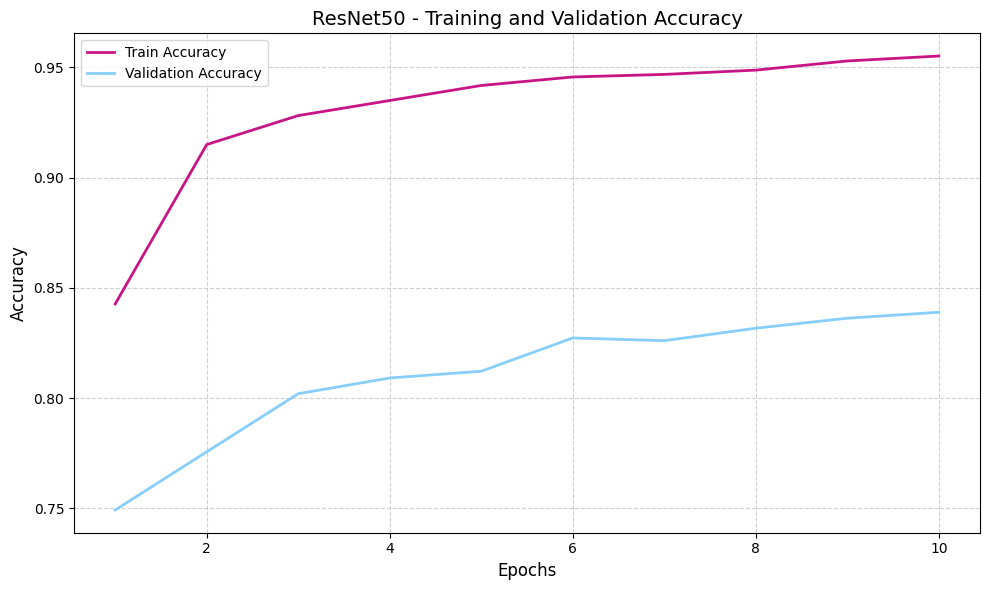

In [ ]:
train_acc_resnet = resnet_history_final['resnet_train_acc']
val_acc_resnet = resnet_history_final['resnet_val_acc']
epochs_range = range(1, len(train_acc_resnet) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_acc_resnet, color="#C71585", label="Train Accuracy", linewidth=2)
plt.plot(epochs_range, val_acc_resnet, color="#87CEFA", label="Validation Accuracy", linewidth=2)
plt.title("ResNet50 - Training and Validation Accuracy", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pretrained EfficientNet-B0
effnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Freeze feature extractor
for param in effnet.features.parameters():
    param.requires_grad = False

# Replace final classifier layer
num_features = effnet.classifier[1].in_features
effnet.classifier[1] = nn.Linear(num_features, len(categories))

# Unfreeze last classifier layer
for param in effnet.classifier[1:].parameters():
    param.requires_grad = True

effnet = effnet.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(effnet.classifier[1:].parameters(), lr=1e-4)

def efficient_train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=3):
    efficient_history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": [],
        "val_precision": [], "val_recall": [], "val_f1": []
    }

    best_val_acc = 0.0
    counter = 0

    with mlflow.start_run(nested=True):
        mlflow.log_param("architecture", "EfficientNet-B0")
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("optimizer", "Adam")
        mlflow.log_param("learning_rate", 1e-4)

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0

            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                correct_train += (preds == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            train_acc = correct_train / len(train_loader.dataset)
            efficient_history["train_loss"].append(epoch_loss)
            efficient_history["train_acc"].append(train_acc)

            # Validation
            model.eval()
            val_loss = 0.0
            correct_val = 0
            all_preds = []
            all_labels = []

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * images.size(0)

                    preds = outputs.argmax(dim=1)
                    correct_val += (preds == labels).sum().item()

                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            val_loss /= len(val_loader.dataset)
            val_acc = correct_val / len(val_loader.dataset)

            # Precision, Recall, F1
            val_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
            val_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
            val_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

            efficient_history["val_loss"].append(val_loss)
            efficient_history["val_acc"].append(val_acc)
            efficient_history["val_precision"].append(val_precision)
            efficient_history["val_recall"].append(val_recall)
            efficient_history["val_f1"].append(val_f1)

            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"Train Loss: {epoch_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
                  f"Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f}")

            # Log metrics
            mlflow.log_metric("train_loss", epoch_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)
            mlflow.log_metric("val_acc", val_acc, step=epoch)
            mlflow.log_metric("val_precision", val_precision, step=epoch)
            mlflow.log_metric("val_recall", val_recall, step=epoch)
            mlflow.log_metric("val_f1", val_f1, step=epoch)

            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                counter = 0
            else:
                counter += 1
                print(f"No improvement for {counter} epochs")
                if counter >= patience:
                    print("Early stopping triggered!")
                    break

    return model, efficient_history

# Train
effnet, efficient_history = efficient_train_model(
    effnet, train_loader, val_loader, criterion, optimizer,
    epochs=10, patience=3
)

print("Training complete")


Using device: cuda
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 166MB/s]
Epoch 1/10: 100%|██████████| 1188/1188 [01:28<00:00, 13.37it/s]


Epoch [1/10] Train Loss: 1.5136 | Train Acc: 0.5168 | Val Loss: 1.3630 | Val Acc: 0.5528 | Precision: 0.6252 | Recall: 0.5528 | F1: 0.5058


Epoch 2/10: 100%|██████████| 1188/1188 [01:38<00:00, 12.10it/s]


Epoch [2/10] Train Loss: 0.6990 | Train Acc: 0.7215 | Val Loss: 0.9424 | Val Acc: 0.6692 | Precision: 0.7040 | Recall: 0.6692 | F1: 0.6316


Epoch 3/10: 100%|██████████| 1188/1188 [01:37<00:00, 12.15it/s]


Epoch [3/10] Train Loss: 0.5149 | Train Acc: 0.7855 | Val Loss: 0.7398 | Val Acc: 0.7260 | Precision: 0.7509 | Recall: 0.7260 | F1: 0.6892


Epoch 4/10: 100%|██████████| 1188/1188 [01:31<00:00, 13.05it/s]


Epoch [4/10] Train Loss: 0.4206 | Train Acc: 0.8196 | Val Loss: 0.6683 | Val Acc: 0.7423 | Precision: 0.8121 | Recall: 0.7423 | F1: 0.7090


Epoch 5/10: 100%|██████████| 1188/1188 [01:31<00:00, 13.01it/s]


Epoch [5/10] Train Loss: 0.3710 | Train Acc: 0.8385 | Val Loss: 0.5931 | Val Acc: 0.7615 | Precision: 0.8255 | Recall: 0.7615 | F1: 0.7317


Epoch 6/10: 100%|██████████| 1188/1188 [01:33<00:00, 12.73it/s]


Epoch [6/10] Train Loss: 0.3330 | Train Acc: 0.8541 | Val Loss: 0.5428 | Val Acc: 0.7785 | Precision: 0.8278 | Recall: 0.7785 | F1: 0.7538


Epoch 7/10: 100%|██████████| 1188/1188 [01:47<00:00, 11.09it/s]


Epoch [7/10] Train Loss: 0.3111 | Train Acc: 0.8582 | Val Loss: 0.5103 | Val Acc: 0.7885 | Precision: 0.8364 | Recall: 0.7885 | F1: 0.7659


Epoch 8/10: 100%|██████████| 1188/1188 [01:29<00:00, 13.32it/s]


Epoch [8/10] Train Loss: 0.2953 | Train Acc: 0.8670 | Val Loss: 0.5019 | Val Acc: 0.7911 | Precision: 0.8417 | Recall: 0.7911 | F1: 0.7693


Epoch 9/10: 100%|██████████| 1188/1188 [01:32<00:00, 12.80it/s]


Epoch [9/10] Train Loss: 0.2790 | Train Acc: 0.8728 | Val Loss: 0.4864 | Val Acc: 0.7977 | Precision: 0.8436 | Recall: 0.7977 | F1: 0.7781


Epoch 10/10: 100%|██████████| 1188/1188 [01:37<00:00, 12.13it/s]


Epoch [10/10] Train Loss: 0.2707 | Train Acc: 0.8748 | Val Loss: 0.4707 | Val Acc: 0.8042 | Precision: 0.8508 | Recall: 0.8042 | F1: 0.7888
🏃 View run painted-perch-732 at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0/runs/50540e89e9b341daa05d847c90f6a5f4
🧪 View experiment at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0
Training complete


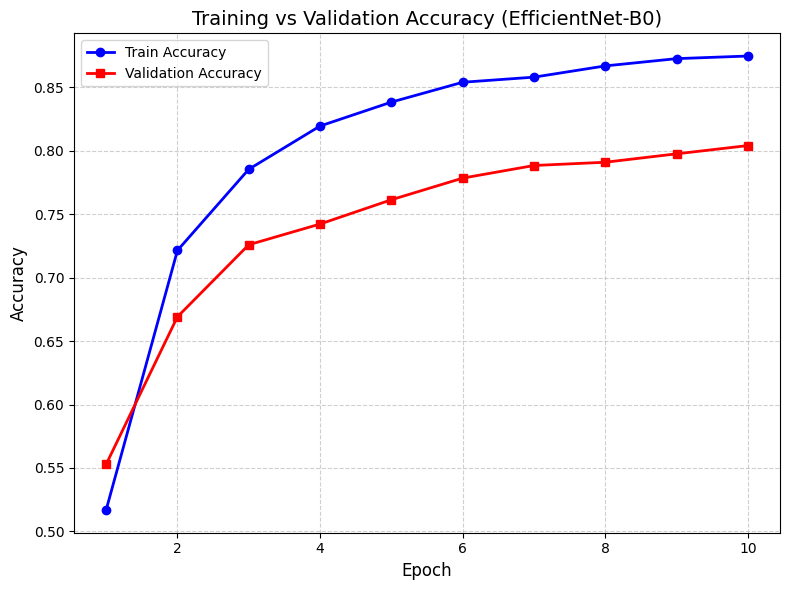

In [ ]:
epochs = range(1, len(efficient_history["train_acc"]) + 1)

plt.figure(figsize=(8,6))
plt.plot(epochs, efficient_history["train_acc"], label="Train Accuracy", marker='o', color='blue', linewidth=2)
plt.plot(epochs, efficient_history["val_acc"], label="Validation Accuracy", marker='s', color='red', linewidth=2)
plt.title("Training vs Validation Accuracy (EfficientNet-B0)", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## **Insights**

- **Steady learning**: Training accuracy improves across epochs.  
- **Validation rises smoothly**:Showing consistent generalization.  
- **Small gap**: The difference between training and validation  is smaller than with VGG16 and ResNet50 : less overfitting.  
- **Good convergence**: Both curves keep improving without strong plateau, suggesting EfficientNet-B0 is learning efficiently.  
- **Next steps**: Could benefit from more epochs or fine-tuning LR schedule; overfitting risk is minimal compared to other models.  


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def effmodel_objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_float("effmodel_lr", 1e-5, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical("effmodel_optimizer", ["Adam", "SGD"])
    dropout_rate = trial.suggest_float("effmodel_dropout", 0.2, 0.7)
    batch_size = trial.suggest_categorical("effmodel_batch_size", [16, 32, 64])

    # Load pretrained EfficientNet-B0
    effmodel = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

    # Freeze feature extractor
    for param in effmodel.features.parameters():
        param.requires_grad = False

    # Replace classifier
    num_features = effmodel.classifier[1].in_features
    effmodel.classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(num_features, len(categories))
    )

    effmodel = effmodel.to(device)

    # Loss and optimizer
    effmodel_criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    if optimizer_name == "Adam":
        effmodel_optimizer = optim.Adam(effmodel.classifier.parameters(), lr=lr)
    else:
        effmodel_optimizer = optim.SGD(effmodel.classifier.parameters(), lr=lr, momentum=0.9)

    effmodel_epochs = 3
    effmodel_best_val_acc = 0.0

    for epoch in range(effmodel_epochs):
        # Training phase
        effmodel.train()
        effmodel_correct_train, effmodel_total_train, effmodel_running_loss = 0, 0, 0.0

        for images, labels in tqdm(train_loader, desc=f"EffModel Trial {trial.number} - Epoch {epoch+1}/{effmodel_epochs}"):
            images, labels = images.to(device), labels.to(device)
            effmodel_optimizer.zero_grad()
            outputs = effmodel(images)
            loss = effmodel_criterion(outputs, labels)
            loss.backward()
            effmodel_optimizer.step()

            effmodel_running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            effmodel_correct_train += (preds == labels).sum().item()
            effmodel_total_train += labels.size(0)

        effmodel_train_acc = effmodel_correct_train / effmodel_total_train

        # Validation phase
        effmodel.eval()
        effmodel_correct_val, effmodel_total_val, effmodel_val_loss = 0, 0, 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = effmodel(images)
                loss = effmodel_criterion(outputs, labels)
                effmodel_val_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                effmodel_correct_val += (preds == labels).sum().item()
                effmodel_total_val += labels.size(0)

        effmodel_val_acc = effmodel_correct_val / effmodel_total_val
        effmodel_val_loss /= effmodel_total_val

        print(f"Epoch {epoch+1}/{effmodel_epochs} | EffModel Train Acc: {effmodel_train_acc:.4f} | EffModel Val Acc: {effmodel_val_acc:.4f}")

        if effmodel_val_acc > effmodel_best_val_acc:
            effmodel_best_val_acc = effmodel_val_acc

    return effmodel_best_val_acc


# Run Optuna study for EffModel
effmodel_study = optuna.create_study(direction="maximize")
effmodel_study.optimize(effmodel_objective, n_trials=10)

# Show best results
print("\nBest EffModel Trial:")
best_trial = effmodel_study.best_trial
print(f"  EffModel Validation Accuracy: {best_trial.value:.4f}")
print("  EffModel Best Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Visualization
try:
    import optuna.visualization as vis
    vis.plot_optimization_history(effmodel_study).show()
    vis.plot_param_importances(effmodel_study).show()
except Exception as e:
    print(f"Visualization skipped: {e}")


[I 2025-10-09 16:13:33,525] A new study created in memory with name: no-name-11a4f3a5-660e-4332-905d-f9e0cfb4480a


Using device: cuda


EffModel Trial 0 - Epoch 1/3: 100%|██████████| 1188/1188 [01:28<00:00, 13.45it/s]


Epoch 1/3 | EffModel Train Acc: 0.6776 | EffModel Val Acc: 0.7200


EffModel Trial 0 - Epoch 2/3: 100%|██████████| 1188/1188 [01:26<00:00, 13.72it/s]


Epoch 2/3 | EffModel Train Acc: 0.8136 | EffModel Val Acc: 0.7703


EffModel Trial 0 - Epoch 3/3: 100%|██████████| 1188/1188 [01:26<00:00, 13.70it/s]
[I 2025-10-09 16:18:41,234] Trial 0 finished with value: 0.791431377363123 and parameters: {'effmodel_lr': 0.000421632377693381, 'effmodel_optimizer': 'Adam', 'effmodel_dropout': 0.453603151112624, 'effmodel_batch_size': 64}. Best is trial 0 with value: 0.791431377363123.


Epoch 3/3 | EffModel Train Acc: 0.8404 | EffModel Val Acc: 0.7914


EffModel Trial 1 - Epoch 1/3: 100%|██████████| 1188/1188 [01:27<00:00, 13.56it/s]


Epoch 1/3 | EffModel Train Acc: 0.3675 | EffModel Val Acc: 0.4206


EffModel Trial 1 - Epoch 2/3: 100%|██████████| 1188/1188 [01:27<00:00, 13.53it/s]


Epoch 2/3 | EffModel Train Acc: 0.6000 | EffModel Val Acc: 0.5234


EffModel Trial 1 - Epoch 3/3: 100%|██████████| 1188/1188 [01:26<00:00, 13.71it/s]
[I 2025-10-09 16:23:48,944] Trial 1 finished with value: 0.6050822489565431 and parameters: {'effmodel_lr': 4.8391150031687043e-05, 'effmodel_optimizer': 'Adam', 'effmodel_dropout': 0.3773042741195789, 'effmodel_batch_size': 32}. Best is trial 0 with value: 0.791431377363123.


Epoch 3/3 | EffModel Train Acc: 0.6785 | EffModel Val Acc: 0.6051


EffModel Trial 2 - Epoch 1/3: 100%|██████████| 1188/1188 [01:27<00:00, 13.65it/s]


Epoch 1/3 | EffModel Train Acc: 0.2438 | EffModel Val Acc: 0.2174


EffModel Trial 2 - Epoch 2/3: 100%|██████████| 1188/1188 [01:26<00:00, 13.75it/s]


Epoch 2/3 | EffModel Train Acc: 0.4384 | EffModel Val Acc: 0.3087


EffModel Trial 2 - Epoch 3/3: 100%|██████████| 1188/1188 [01:26<00:00, 13.69it/s]
[I 2025-10-09 16:28:55,057] Trial 2 finished with value: 0.34888288730665357 and parameters: {'effmodel_lr': 9.436758768589263e-05, 'effmodel_optimizer': 'SGD', 'effmodel_dropout': 0.4221867997112485, 'effmodel_batch_size': 64}. Best is trial 0 with value: 0.791431377363123.


Epoch 3/3 | EffModel Train Acc: 0.5150 | EffModel Val Acc: 0.3489


EffModel Trial 3 - Epoch 1/3: 100%|██████████| 1188/1188 [01:26<00:00, 13.78it/s]


Epoch 1/3 | EffModel Train Acc: 0.7050 | EffModel Val Acc: 0.7383


EffModel Trial 3 - Epoch 2/3: 100%|██████████| 1188/1188 [01:26<00:00, 13.66it/s]


Epoch 2/3 | EffModel Train Acc: 0.8468 | EffModel Val Acc: 0.7860


EffModel Trial 3 - Epoch 3/3: 100%|██████████| 1188/1188 [01:27<00:00, 13.54it/s]
[I 2025-10-09 16:34:02,114] Trial 3 finished with value: 0.8087404861281611 and parameters: {'effmodel_lr': 0.0003990323236637142, 'effmodel_optimizer': 'Adam', 'effmodel_dropout': 0.20384520595248068, 'effmodel_batch_size': 64}. Best is trial 3 with value: 0.8087404861281611.


Epoch 3/3 | EffModel Train Acc: 0.8680 | EffModel Val Acc: 0.8087


EffModel Trial 4 - Epoch 1/3: 100%|██████████| 1188/1188 [01:27<00:00, 13.65it/s]


Epoch 1/3 | EffModel Train Acc: 0.7105 | EffModel Val Acc: 0.7404


EffModel Trial 4 - Epoch 2/3: 100%|██████████| 1188/1188 [01:26<00:00, 13.72it/s]


Epoch 2/3 | EffModel Train Acc: 0.8341 | EffModel Val Acc: 0.7800


EffModel Trial 4 - Epoch 3/3: 100%|██████████| 1188/1188 [01:32<00:00, 12.90it/s]
[I 2025-10-09 16:39:12,844] Trial 4 finished with value: 0.8033390621163762 and parameters: {'effmodel_lr': 0.0005274180725572983, 'effmodel_optimizer': 'Adam', 'effmodel_dropout': 0.40192673829354897, 'effmodel_batch_size': 32}. Best is trial 3 with value: 0.8087404861281611.


Epoch 3/3 | EffModel Train Acc: 0.8526 | EffModel Val Acc: 0.8033


EffModel Trial 5 - Epoch 1/3: 100%|██████████| 1188/1188 [01:26<00:00, 13.74it/s]


Epoch 1/3 | EffModel Train Acc: 0.1857 | EffModel Val Acc: 0.1485


EffModel Trial 5 - Epoch 2/3: 100%|██████████| 1188/1188 [01:34<00:00, 12.63it/s]


Epoch 2/3 | EffModel Train Acc: 0.3528 | EffModel Val Acc: 0.2309


EffModel Trial 5 - Epoch 3/3: 100%|██████████| 1188/1188 [01:35<00:00, 12.49it/s]
[I 2025-10-09 16:44:36,938] Trial 5 finished with value: 0.2894672231770194 and parameters: {'effmodel_lr': 5.333743427114184e-05, 'effmodel_optimizer': 'SGD', 'effmodel_dropout': 0.4575409213147473, 'effmodel_batch_size': 32}. Best is trial 3 with value: 0.8087404861281611.


Epoch 3/3 | EffModel Train Acc: 0.4372 | EffModel Val Acc: 0.2895


EffModel Trial 6 - Epoch 1/3: 100%|██████████| 1188/1188 [01:33<00:00, 12.67it/s]


Epoch 1/3 | EffModel Train Acc: 0.5363 | EffModel Val Acc: 0.4979


EffModel Trial 6 - Epoch 2/3: 100%|██████████| 1188/1188 [01:33<00:00, 12.68it/s]


Epoch 2/3 | EffModel Train Acc: 0.6947 | EffModel Val Acc: 0.5568


EffModel Trial 6 - Epoch 3/3: 100%|██████████| 1188/1188 [01:50<00:00, 10.75it/s]
[I 2025-10-09 16:50:24,886] Trial 6 finished with value: 0.6109747115148539 and parameters: {'effmodel_lr': 0.0008244647536047903, 'effmodel_optimizer': 'SGD', 'effmodel_dropout': 0.2931904364363002, 'effmodel_batch_size': 16}. Best is trial 3 with value: 0.8087404861281611.


Epoch 3/3 | EffModel Train Acc: 0.7337 | EffModel Val Acc: 0.6110


EffModel Trial 7 - Epoch 1/3: 100%|██████████| 1188/1188 [01:54<00:00, 10.37it/s]


Epoch 1/3 | EffModel Train Acc: 0.2630 | EffModel Val Acc: 0.3181


EffModel Trial 7 - Epoch 2/3: 100%|██████████| 1188/1188 [01:35<00:00, 12.38it/s]


Epoch 2/3 | EffModel Train Acc: 0.4860 | EffModel Val Acc: 0.4276


EffModel Trial 7 - Epoch 3/3: 100%|██████████| 1188/1188 [01:31<00:00, 13.05it/s]
[I 2025-10-09 16:56:20,368] Trial 7 finished with value: 0.4958261723545298 and parameters: {'effmodel_lr': 2.8482983643146528e-05, 'effmodel_optimizer': 'Adam', 'effmodel_dropout': 0.5122991146045814, 'effmodel_batch_size': 32}. Best is trial 3 with value: 0.8087404861281611.


Epoch 3/3 | EffModel Train Acc: 0.5769 | EffModel Val Acc: 0.4958


EffModel Trial 8 - Epoch 1/3: 100%|██████████| 1188/1188 [01:27<00:00, 13.57it/s]


Epoch 1/3 | EffModel Train Acc: 0.1687 | EffModel Val Acc: 0.1651


EffModel Trial 8 - Epoch 2/3: 100%|██████████| 1188/1188 [01:39<00:00, 11.95it/s]


Epoch 2/3 | EffModel Train Acc: 0.3230 | EffModel Val Acc: 0.2618


EffModel Trial 8 - Epoch 3/3: 100%|██████████| 1188/1188 [01:29<00:00, 13.28it/s]
[I 2025-10-09 17:01:45,644] Trial 8 finished with value: 0.34704149275718144 and parameters: {'effmodel_lr': 1.0891048263924525e-05, 'effmodel_optimizer': 'Adam', 'effmodel_dropout': 0.38658090360951014, 'effmodel_batch_size': 32}. Best is trial 3 with value: 0.8087404861281611.


Epoch 3/3 | EffModel Train Acc: 0.4170 | EffModel Val Acc: 0.3470


EffModel Trial 9 - Epoch 1/3: 100%|██████████| 1188/1188 [01:29<00:00, 13.30it/s]


Epoch 1/3 | EffModel Train Acc: 0.6493 | EffModel Val Acc: 0.7098


EffModel Trial 9 - Epoch 2/3: 100%|██████████| 1188/1188 [01:30<00:00, 13.13it/s]


Epoch 2/3 | EffModel Train Acc: 0.7807 | EffModel Val Acc: 0.7561


EffModel Trial 9 - Epoch 3/3: 100%|██████████| 1188/1188 [01:29<00:00, 13.24it/s]
[I 2025-10-09 17:07:01,384] Trial 9 finished with value: 0.7792781733366069 and parameters: {'effmodel_lr': 0.0004845965051570751, 'effmodel_optimizer': 'Adam', 'effmodel_dropout': 0.6208782155851994, 'effmodel_batch_size': 32}. Best is trial 3 with value: 0.8087404861281611.


Epoch 3/3 | EffModel Train Acc: 0.8100 | EffModel Val Acc: 0.7793

Best EffModel Trial:
  EffModel Validation Accuracy: 0.8087
  EffModel Best Hyperparameters:
    effmodel_lr: 0.0003990323236637142
    effmodel_optimizer: Adam
    effmodel_dropout: 0.20384520595248068
    effmodel_batch_size: 64


In [ ]:
best_params = best_trial.params
best_lr = best_params["effmodel_lr"]
best_optimizer_name = best_params["effmodel_optimizer"]
best_dropout = best_params["effmodel_dropout"]
best_batch = best_params["effmodel_batch_size"]

print("\n Best Hyperparameters Used for Final Training (EfficientNet):")
for k, v in best_params.items():
    print(f"   {k}: {v}")

effmodel_final = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
for param in effmodel_final.features.parameters():
    param.requires_grad = False

num_features = effmodel_final.classifier[1].in_features
effmodel_final.classifier = nn.Sequential(
    nn.Dropout(p=best_dropout),
    nn.Linear(num_features, len(categories))
)
effmodel_final = effmodel_final.to(device)

efficient_final_criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
if best_optimizer_name == "Adam":
    efficient_final_optimizer = optim.Adam(effmodel_final.classifier.parameters(), lr=best_lr)
else:
    efficient_final_optimizer = optim.SGD(effmodel_final.classifier.parameters(), lr=best_lr, momentum=0.9)

efficient_train_acc_history = []
efficient_val_acc_history = []
efficient_final_epochs = 10

for epoch in range(efficient_final_epochs):
    effmodel_final.train()
    efficient_running_loss = 0.0
    efficient_correct, efficient_total = 0, 0

    for images, labels in tqdm(train_loader, desc=f"EfficientNet Final Training Epoch {epoch+1}/{efficient_final_epochs}"):
        images, labels = images.to(device), labels.to(device)
        efficient_final_optimizer.zero_grad()
        outputs = effmodel_final(images)
        loss = efficient_final_criterion(outputs, labels)
        loss.backward()
        efficient_final_optimizer.step()

        efficient_running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        efficient_correct += (preds == labels).sum().item()
        efficient_total += labels.size(0)

    efficient_train_acc = efficient_correct / efficient_total
    efficient_train_loss = efficient_running_loss / efficient_total
    efficient_train_acc_history.append(efficient_train_acc)
    print(f"Epoch {epoch+1}/{efficient_final_epochs} | Train Loss: {efficient_train_loss:.4f} | Train Acc: {efficient_train_acc:.4f}")

    effmodel_final.eval()
    efficient_correct_val, efficient_total_val = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = effmodel_final(images)
            preds = outputs.argmax(dim=1)
            efficient_correct_val += (preds == labels).sum().item()
            efficient_total_val += labels.size(0)

    efficient_val_acc = efficient_correct_val / efficient_total_val
    efficient_val_acc_history.append(efficient_val_acc)
    print(f"           Validation Acc: {efficient_val_acc:.4f}")

effmodel_final.eval()
efficient_all_preds = []
efficient_all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating Final Model"):
        images, labels = images.to(device), labels.to(device)
        outputs = effmodel_final(images)
        preds = outputs.argmax(dim=1)
        efficient_all_preds.extend(preds.cpu().numpy())
        efficient_all_labels.extend(labels.cpu().numpy())

efficient_final_acc = accuracy_score(efficient_all_labels, efficient_all_preds)
efficient_final_precision = precision_score(efficient_all_labels, efficient_all_preds, average='weighted', zero_division=0)
efficient_final_recall = recall_score(efficient_all_labels, efficient_all_preds, average='weighted', zero_division=0)
efficient_final_f1 = f1_score(efficient_all_labels, efficient_all_preds, average='weighted', zero_division=0)

print("\nEfficientNet Final Model Evaluation:")
print(f"   Accuracy : {efficient_final_acc:.4f}")
print(f"   Precision: {efficient_final_precision:.4f}")
print(f"   Recall   : {efficient_final_recall:.4f}")
print(f"   F1 Score : {efficient_final_f1:.4f}")

#  7. MLflow Logging
mlflow.end_run()
with mlflow.start_run(run_name="EfficientNet_Final_Training"):

    # Params
    mlflow.log_param("efficient_learning_rate", best_lr)
    mlflow.log_param("efficient_optimizer", best_optimizer_name)
    mlflow.log_param("efficient_dropout", best_dropout)
    mlflow.log_param("efficient_batch_size", best_batch)
    mlflow.log_param("efficient_epochs", efficient_final_epochs)

    # Metrics
    mlflow.log_metric("efficient_final_accuracy", efficient_final_acc)
    mlflow.log_metric("efficient_final_precision", efficient_final_precision)
    mlflow.log_metric("efficient_final_recall", efficient_final_recall)
    mlflow.log_metric("efficient_final_f1_score", efficient_final_f1)

    #  Save model manually instead of mlflow.pytorch.log_model
    model_path = "EfficientNet_Final_Model.pth"
    torch.save(effmodel_final.state_dict(), model_path)
    mlflow.log_artifact(model_path)

    print("\nEfficientNet model has been saved locally and logged to MLflow as artifact successfully!")



 Best Hyperparameters Used for Final Training (EfficientNet):
   effmodel_lr: 0.0003990323236637142
   effmodel_optimizer: Adam
   effmodel_dropout: 0.20384520595248068
   effmodel_batch_size: 64


EfficientNet Final Training Epoch 1/10: 100%|██████████| 1188/1188 [01:28<00:00, 13.48it/s]

Epoch 1/10 | Train Loss: 0.7964 | Train Acc: 0.7086


           Validation Acc: 0.7482


EfficientNet Final Training Epoch 2/10: 100%|██████████| 1188/1188 [01:26<00:00, 13.75it/s]

Epoch 2/10 | Train Loss: 0.3479 | Train Acc: 0.8450


           Validation Acc: 0.7879


EfficientNet Final Training Epoch 3/10:  51%|█████     | 607/1188 [00:44<00:37, 15.30it/s]

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(range(1, efficient_final_epochs+1), efficient_train_acc_history,
         label='Efficient Train Accuracy', marker='o', color="#C71585")
plt.plot(range(1, efficient_final_epochs+1), efficient_val_acc_history,
         label='Efficient Validation Accuracy', marker='o', color="#87CEFA")
plt.title('EfficientNet-B0 - Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
best_model=effmodel_final
best_model.eval()
all_test_preds = []
all_test_labels = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Data"):
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        preds = outputs.argmax(dim=1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())
Test_acc = accuracy_score(all_test_labels, all_test_preds)
Test_precision = precision_score(all_test_labels, all_test_preds, average='weighted', zero_division=0)
Test_recall = recall_score(all_test_labels, all_test_preds, average='weighted', zero_division=0)
Test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted', zero_division=0)
print("\nTest Data Results:")
print(f"Accuracy : {Test_acc:.4f}")
print(f"Precision: {Test_precision:.4f}")
print(f"Recall   : {Test_recall:.4f}")
print(f"F1 Score : {Test_f1:.4f}")
# Confusion Matrix
cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
with mlflow.start_run(run_name="Test_Evaluation"):
    for k, v in best_params.items():
        mlflow.log_param(k, v)
    # Metrics
    mlflow.log_metric("Test_accuracy", Test_acc)
    mlflow.log_metric("Test_precision", Test_precision)
    mlflow.log_metric("Test_recall", Test_recall)
    mlflow.log_metric("Test_f1", Test_f1)
    mlflow.pytorch.log_model(best_model, artifact_path="Best_Model_Test")
print("\n Test results logged to MLflow successfully!")

In [ ]:
disease_classes = [i for i, c in enumerate(categories) if "healthy" not in c.lower()]
healthy_classes = [i for i, c in enumerate(categories) if "healthy" in c.lower()]
best_model.eval()
post_preds = []

with torch.no_grad():
    for images, _ in tqdm(test_loader, desc="Post-Processing Test Data"):
        images = images.to(device)
        outputs = best_model(images)
        probs = F.softmax(outputs, dim=1)

        for prob in probs:
            prob_disease = prob[disease_classes].sum().item()
            prob_healthy = prob[healthy_classes].sum().item()

            if prob_disease > prob_healthy:
                post_preds.append("Diseased")
            else:
                post_preds.append("Healthy")

In [ ]:
# transform = base_transform

# img_path = "path_to_new_plant_image.jpg"
# img = Image.open(img_path).convert("RGB")
# img_tensor = transform(img).unsqueeze(0).to(device)

# best_model.eval()
# with torch.no_grad():
#     output = best_model(img_tensor)
#     probs = F.softmax(output, dim=1).squeeze()
#     prob_disease = probs[disease_classes].sum().item()
#     prob_healthy = probs[healthy_classes].sum().item()

#     result = "Diseased" if prob_disease > prob_healthy else "Healthy"
#     print("Prediction for new plant:", result)